## Supervised Clustering with SHAP Values

---------------------------------

### Importing libraries, preparing data and creating functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib import style
from datetime import datetime

from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.mixture import GaussianMixture

from umap import UMAP
import umap
import umap.plot
#from sklearn.manifold import TSNE

import xgboost as xgb
import shap



shap.initjs()

In [2]:
#time function to track running time
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now()- start_time).total_seconds(), 3600)
        tmin, tsec= divmod(temp_sec, 60)
        print("\n Time taken: %i hours %i minutes and %i seconds." % (thour, tmin, round(tsec,2)))
        
#function to calculate features to remove based on correlation
def correlation(dataset, threshold):
    col_corr=set()
    corr_matrix=dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname=corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

#Calculate accuracy and fale positive rate of binary classification
def accuracy0MalwareClass(dataset):
    count= 0
    for i in range(len(dataset)):
        if (dataset["Cluster"][i]== 0 and dataset["Class"][i]== "Malware") or (dataset["Cluster"][i]== 1 and dataset["Class"][i]== "Benign"):
            count += 1
        
    return print("Accuracy:", count/len(dataset)*100, "% \n False Positive rate:", len(dataset[dataset.Cluster==1][dataset.Class== "Malware"])/(len(dataset[dataset.Cluster==1][dataset.Class== "Malware"])+len(dataset[dataset.Cluster==0][dataset.Class=="Malware"])) * 100, "%") 

def accuracy0BenignClass(dataset):
    count= 0
    for i in range(len(dataset)):
        if (dataset["Cluster"][i]== 1 and dataset["Class"][i]== "Malware") or (dataset["Cluster"][i]== 0 and dataset["Class"][i]== "Benign"):
            count += 1
        
    return print("Accuracy:", count/len(dataset)*100, "% \n False Positive rate:", len(dataset[dataset.Cluster==0][dataset.Class== "Malware"])/(len(dataset[dataset.Cluster==0][dataset.Class== "Malware"])+len(dataset[dataset.Cluster==1][dataset.Class=="Malware"])) * 100, "%") 

def elbow_method(dataset):
    wcss = []
    for i in range(2, 16):
    
        model =KMeans(n_clusters=i)
        model.fit(dataset[["x", "y"]])
        wcss.append(model.inertia_)
    plt.plot(range(2, 16), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

In [3]:
#Importing the data 
dataset= pd.read_csv("C:/Users/rodri/OneDrive/Desktop/tese/Data/Obfuscated-MalMem2022.csv")

#Separating the Category column into category and family
dataset[["Category", "Family1", "idk"]]=dataset["Category"].str.split("-", n=2, expand= True)
dataset.drop("idk",axis=1, inplace= True)


#Arranging the family column
classes=[]
for i in range(len(dataset)):
    if dataset["Class"][i]== "Benign":
        classes.append("Benign")
    else:
        classes.append(dataset["Family1"][i])
dataset["Family"]= classes

dataset.drop("Family1", axis=1,inplace= True)

#Dropping meaningless features
dataset.drop(["pslist.nprocs64bit","handles.nport","svcscan.interactive_process_services"], axis= 1, inplace= True)


In [4]:
pd.set_option('display.max_columns', None)
dataset.describe()

pslist.nproc  pslist.nppid  pslist.avg_threads  pslist.avg_handlers  \
count  58596.000000  58596.000000        58596.000000         58596.000000   
mean      41.394771     14.713837           11.341655           247.509819   
std        5.777249      2.656748            1.588231           111.857790   
min       21.000000      8.000000            1.650000            34.962500   
25%       40.000000     12.000000            9.972973           208.725000   
50%       41.000000     15.000000           11.000000           243.963710   
75%       43.000000     16.000000           12.861955           289.974322   
max      240.000000     72.000000           16.818182         24845.951220   

       dlllist.ndlls  dlllist.avg_dlls_per_proc  handles.nhandles  \
count   58596.000000               58596.000000      5.859600e+04   
mean     1810.805447                  43.707806      1.025858e+04   
std       329.782639                   5.742023      4.866864e+03   
min       670.000000                   7.333333      3.514000e+03   
25%      1556.000000                  38.833333      8.393000e+03   
50%      1735.000000                  42.781524      9.287500e+03   
75%      2087.000000                  49.605280      1.219300e+04   
max      3443.000000                  53.170732      1.047310e+06   

       handles.avg_handles_per_proc  handles.nfile  handles.nevent  \
count                  58596.000000   58596.000000    58596.000000   
mean                     249.560958     899.119513     3572.409960   
std                      145.999866    3432.351200      805.460522   
min                       71.139241     266.000000      966.000000   
25%                      209.648228     646.000000     2923.000000   
50%                      247.208951     839.000000     3151.000000   
75%                      291.355050    1080.000000     4321.000000   
max                    33784.193550  807008.000000     7892.000000   

       handles.ndesktop  handles.nkey  handles.nthread  handles.ndirectory  \
count      58596.000000  58596.000000     58596.000000        58596.000000   
mean          44.529166    774.280668       928.510086          102.398338   
std            5.161254    150.407075       237.817566            9.782695   
min           22.000000    284.000000       388.000000           57.000000   
25%           43.000000    675.000000       708.000000           99.000000   
50%           45.000000    753.000000       848.000000          103.000000   
75%           46.000000    859.000000      1169.000000          107.000000   
max          159.000000   2668.000000      5637.000000          498.000000   

       handles.nsemaphore  handles.ntimer  handles.nsection  handles.nmutant  \
count        58596.000000    58596.000000      58596.000000     58596.000000   
mean           683.339324      130.327855        290.127466       312.588829   
std             94.531078       14.965266        144.278832        73.173189   
min            296.000000       69.000000         50.000000       118.000000   
25%            614.000000      120.000000        177.000000       258.000000   
50%            684.000000      131.000000        224.000000       289.000000   
75%            750.000000      142.000000        415.000000       366.000000   
max           4268.000000      382.000000      14687.000000       583.000000   

       ldrmodules.not_in_load  ldrmodules.not_in_init  ldrmodules.not_in_mem  \
count            58596.000000            58596.000000           58596.000000   
mean                60.830347               99.946413              60.832599   
std                 18.761422               21.438482              18.759947   
min                  6.000000               16.000000               6.000000   
25%                 46.000000               85.000000              46.000000   
50%                 57.000000               97.000000              57.000000   
75%                 74.000000              115.000000              

In [5]:
list(dataset)

['Category',
 'pslist.nproc',
 'pslist.nppid',
 'pslist.avg_threads',
 'pslist.avg_handlers',
 'dlllist.ndlls',
 'dlllist.avg_dlls_per_proc',
 'handles.nhandles',
 'handles.avg_handles_per_proc',
 'handles.nfile',
 'handles.nevent',
 'handles.ndesktop',
 'handles.nkey',
 'handles.nthread',
 'handles.ndirectory',
 'handles.nsemaphore',
 'handles.ntimer',
 'handles.nsection',
 'handles.nmutant',
 'ldrmodules.not_in_load',
 'ldrmodules.not_in_init',
 'ldrmodules.not_in_mem',
 'ldrmodules.not_in_load_avg',
 'ldrmodules.not_in_init_avg',
 'ldrmodules.not_in_mem_avg',
 'malfind.ninjections',
 'malfind.commitCharge',
 'malfind.protection',
 'malfind.uniqueInjections',
 'psxview.not_in_pslist',
 'psxview.not_in_eprocess_pool',
 'psxview.not_in_ethread_pool',
 'psxview.not_in_pspcid_list',
 'psxview.not_in_csrss_handles',
 'psxview.not_in_session',
 'psxview.not_in_deskthrd',
 'psxview.not_in_pslist_false_avg',
 'psxview.not_in_eprocess_pool_false_avg',
 'psxview.not_in_ethread_pool_false_avg',

-----------------------

### Removing correlated features

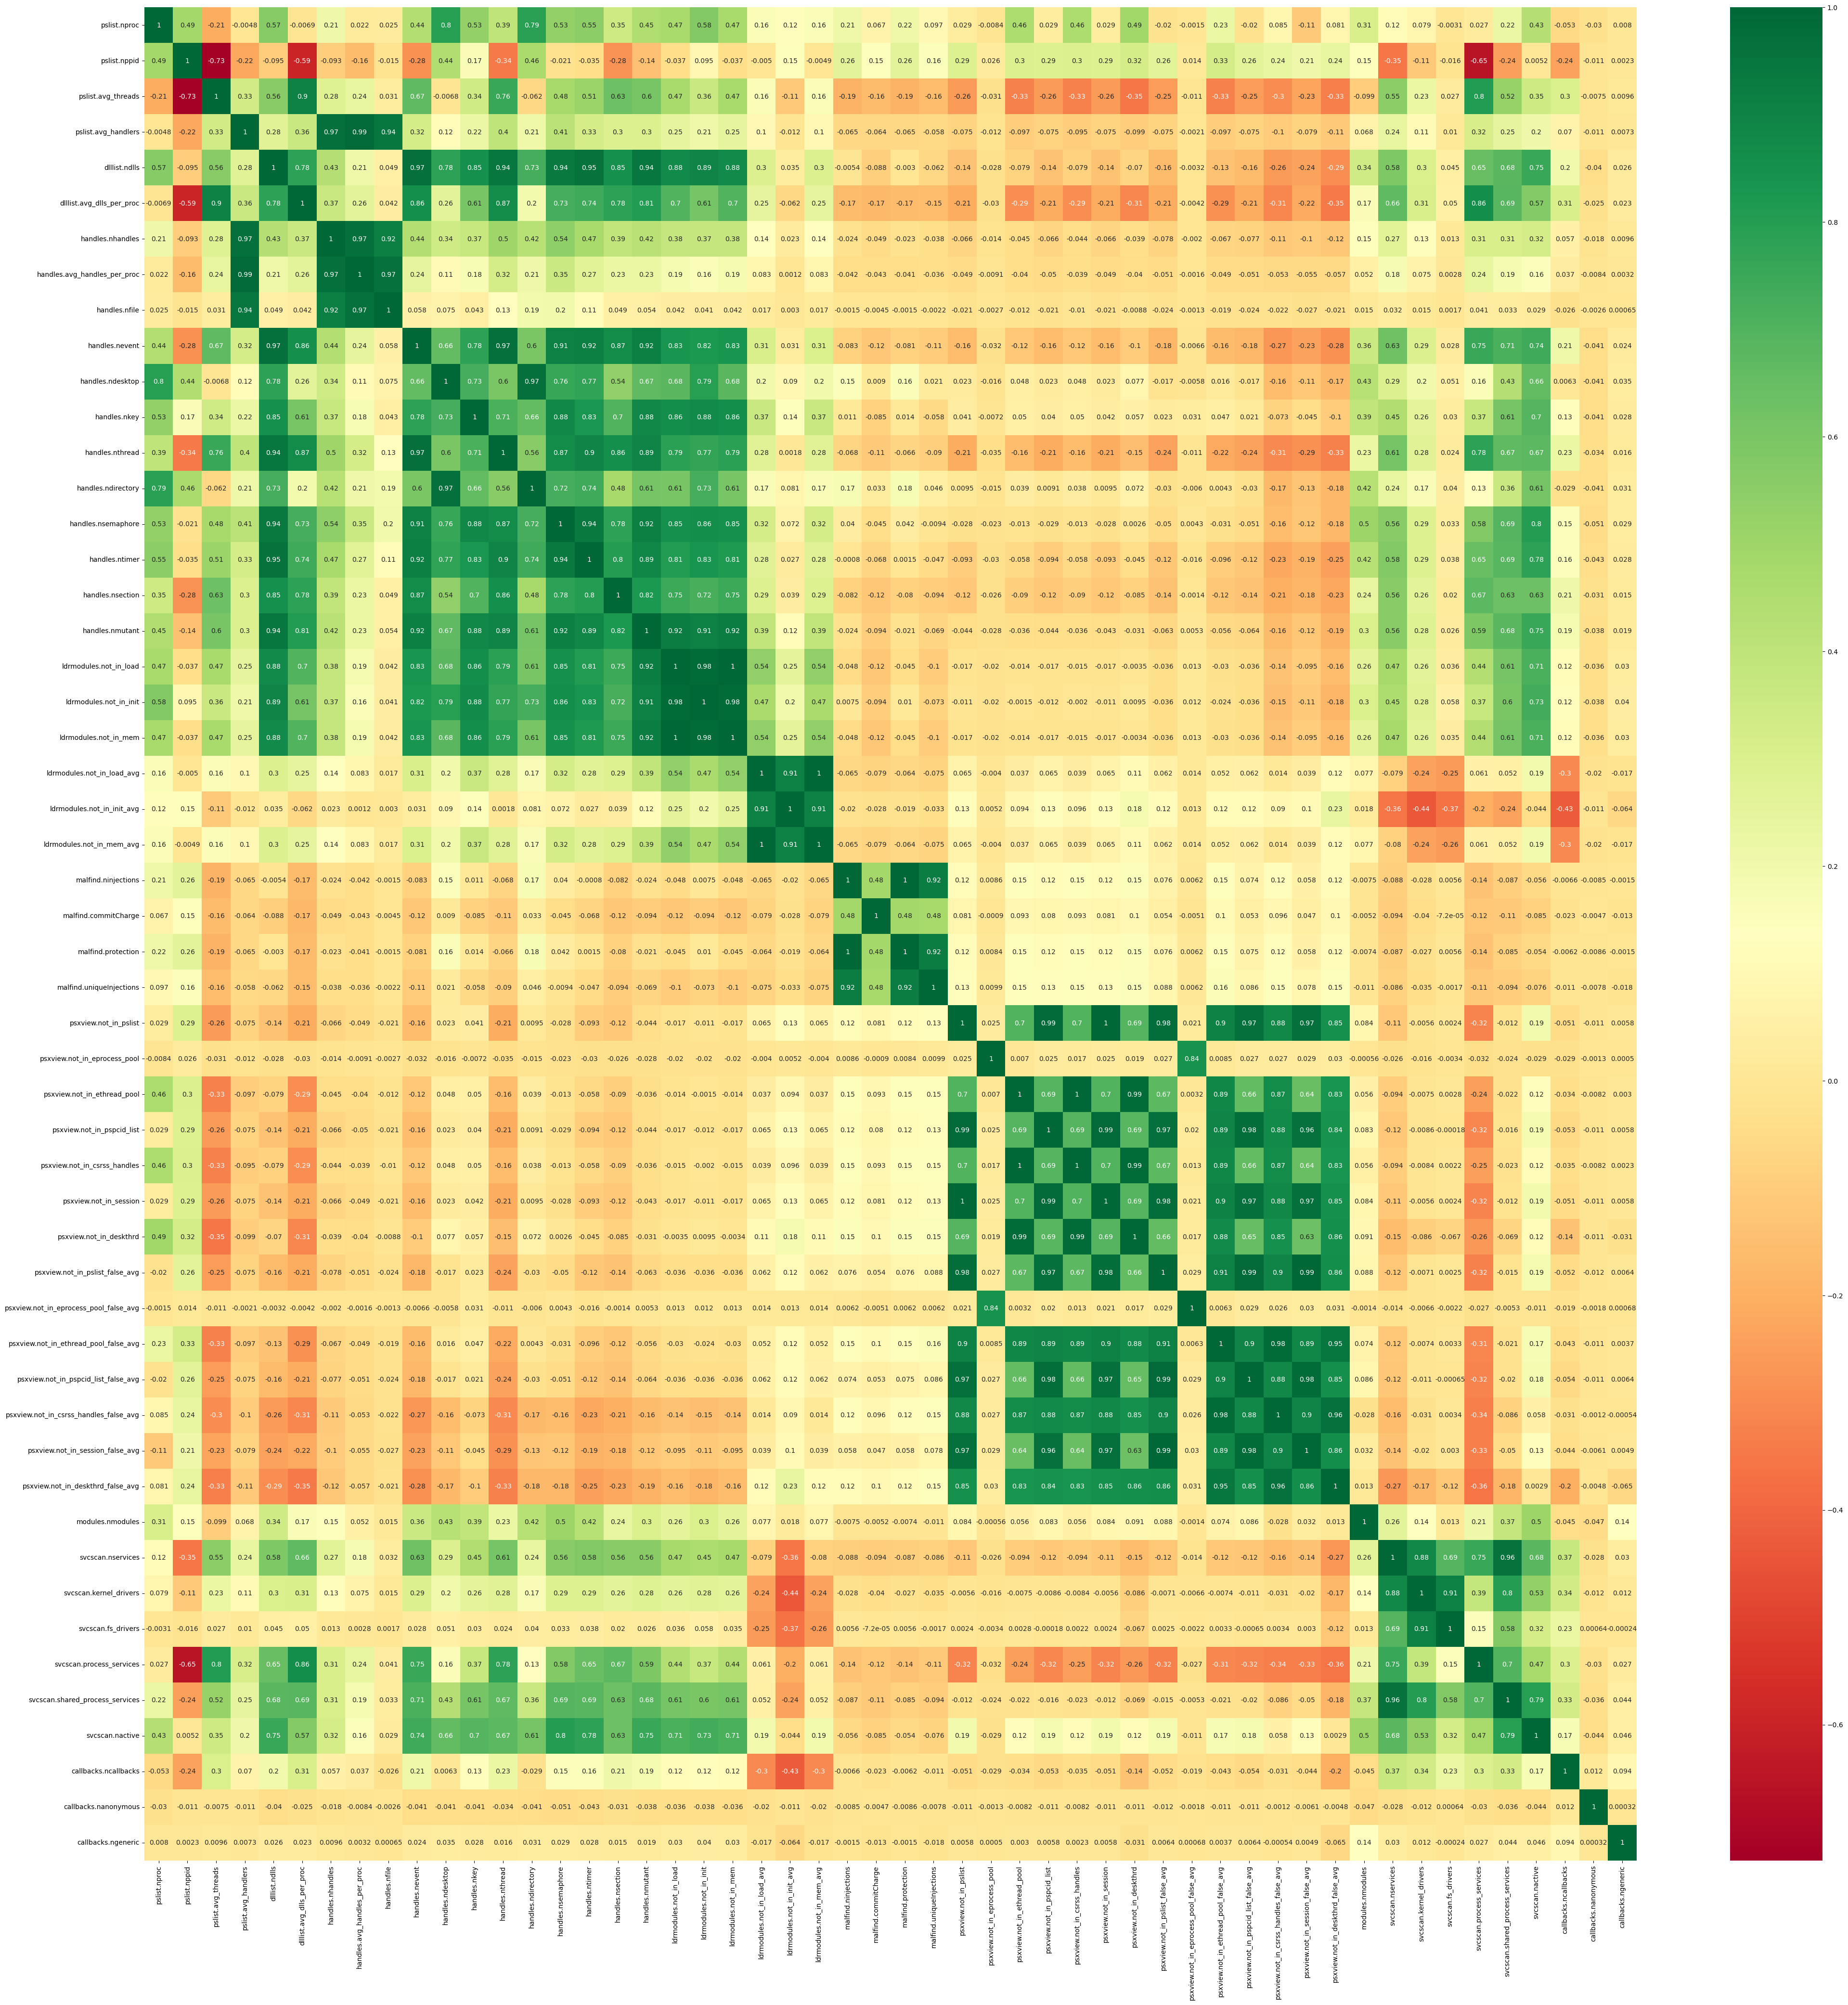

In [131]:
corrmat=dataset.drop(["Category","Class", "Family"],axis=1).corr()
top_corr_feats=corrmat.index
plt.figure(figsize=(50,50))
g= sns.heatmap(dataset[top_corr_feats].corr(), annot=True, cmap="RdYlGn")

In [132]:
#Using correlation for feature selection as it works better with SHAP values
dataset1= dataset.copy()
dataset1.drop(["Category","Class", "Family"], axis=1, inplace= True)

corr_features=correlation(dataset1, 0.7)
dataset1.drop(corr_features, axis=1, inplace= True)
FeaturesCorr=dataset1.columns
dataset1["Category"]= dataset.Category
dataset1["Class"]= dataset.Class
dataset1["Family"]= dataset.Family

### Dataset analysis

Text(0.5, 1.0, 'Benign and Malware sample distribution')

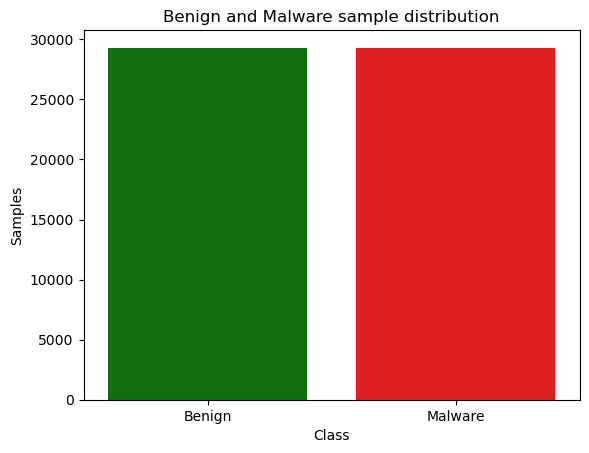

In [133]:
ax=sns.countplot(x="Class", data=dataset, palette=["Green", "Red", "Purple", "Orange"])
ax.grid(False)
plt.ylabel("Samples")
plt.title("Benign and Malware sample distribution")

Text(0.5, 1.0, 'Malware Category distribution')

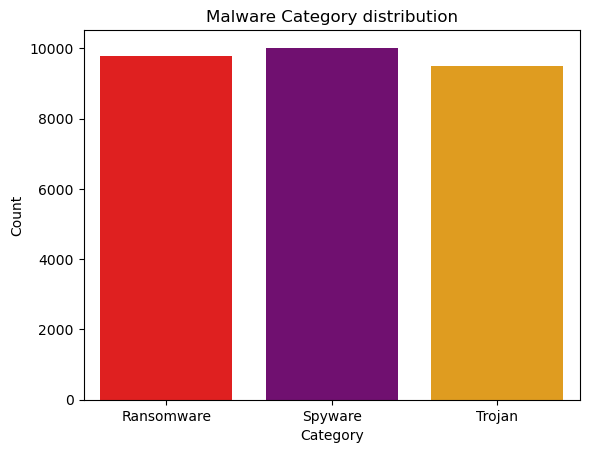

In [134]:
ax=sns.countplot(x="Category", data=dataset[dataset.Class=="Malware"], palette=["Red", "Purple", "Orange"])
ax.grid(False)
plt.ylabel("Count")
plt.title("Malware Category distribution")

"\nplt.yticks(\n    rotation=45, \n    horizontalalignment='right',\n    fontweight='light',\n    #fontsize='x-large'  \n)\n"

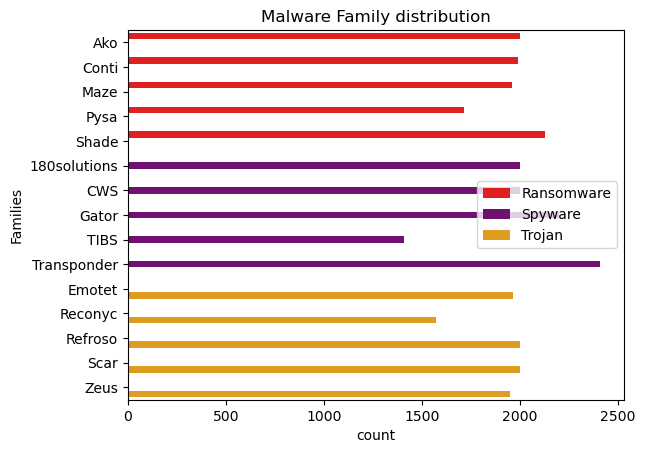

In [135]:
ax=sns.countplot(y="Family",hue= "Category",data=dataset[dataset.Class=="Malware"], palette=["red", "purple", "Orange"])
ax.grid(False)
plt.legend(loc='center right')
plt.ylabel("Families")
plt.title("Malware Family distribution")

"""
plt.yticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    #fontsize='x-large'  
)
"""

Text(0.5, 1.0, 'Malware Family distribution')

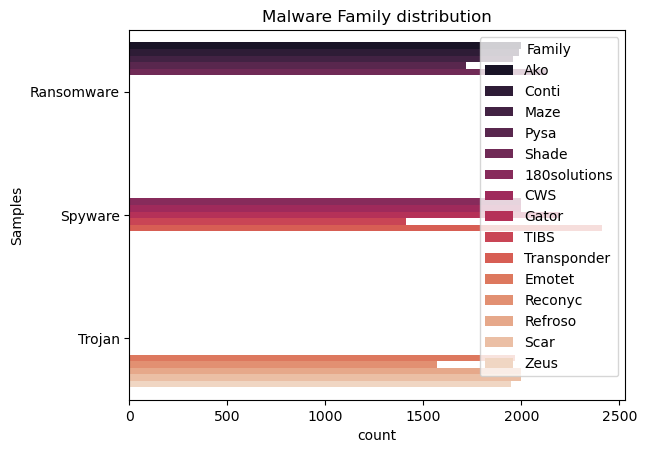

In [136]:
ax=sns.countplot(y="Category", hue= "Family", data=dataset[dataset.Class=="Malware"], palette="rocket")
ax.grid(False)
plt.ylabel("Samples")
plt.title("Malware Family distribution")


In [137]:
dataset1.head()

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0            45            17           202.844444           1694   
1            47            19           242.234043           2074   
2            40            14           288.225000           1932   
3            32            13           264.281250           1445   
4            42            16           281.333333           2067   

   ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                    0.030372                    5                    21   
1                    0.036167                   12                    77   
2                    0.026114                    5                     6   
3                    0.021483                    2                     2   
4                    0.047820                   12                    77   

   psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                      2                             0               138   
1                      0                             0               138   
2                      0                             0               137   
3                      0                             0               138   
4                      4                             0               138   

   svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0                389                    87                     0   
1                392                    87                     0   
2                395                    88                     0   
3                395                    88                     0   
4                392                    87                     0   

   callbacks.ngeneric Category   Class  Family  
0                   8   Benign  Benign  Benign  
1                   8   Benign  Benign  Benign  
2                   8   Benign  Benign  Benign  
3                   8   Benign  Benign  Benign  
4                   8   Benign  Benign  Benign

In [138]:
list(dataset1)

['pslist.nproc',
 'pslist.nppid',
 'pslist.avg_handlers',
 'dlllist.ndlls',
 'ldrmodules.not_in_load_avg',
 'malfind.ninjections',
 'malfind.commitCharge',
 'psxview.not_in_pslist',
 'psxview.not_in_eprocess_pool',
 'modules.nmodules',
 'svcscan.nservices',
 'callbacks.ncallbacks',
 'callbacks.nanonymous',
 'callbacks.ngeneric',
 'Category',
 'Class',
 'Family']

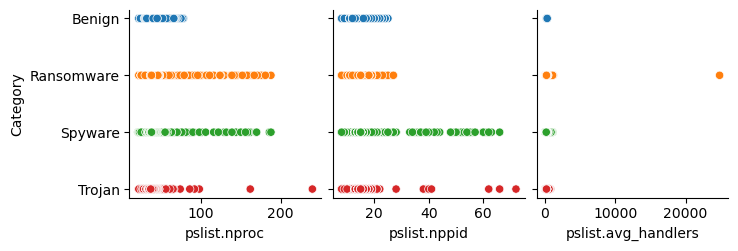

In [139]:
#sns.pairplot(dataset1,x_vars=x, y_vars=y,kind="scatter")
sns.pairplot(dataset1,x_vars=['pslist.nproc',
 'pslist.nppid',
 'pslist.avg_handlers'],y_vars=["Category"],hue="Category", kind="scatter")._legend.remove()

      
#sns.pairplot(dataset1,x_vars=dataset1.drop(["Category","Class","Family"], axis=1), y_vars=dataset1["Class"], hue="Category")

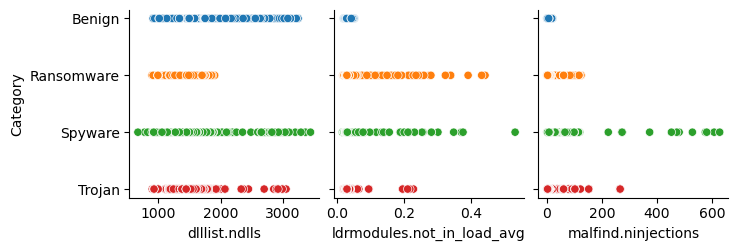

In [140]:
sns.pairplot(dataset1,x_vars=['dlllist.ndlls',
 'ldrmodules.not_in_load_avg',
 'malfind.ninjections'],y_vars=["Category"],hue="Category", kind="scatter")._legend.remove()

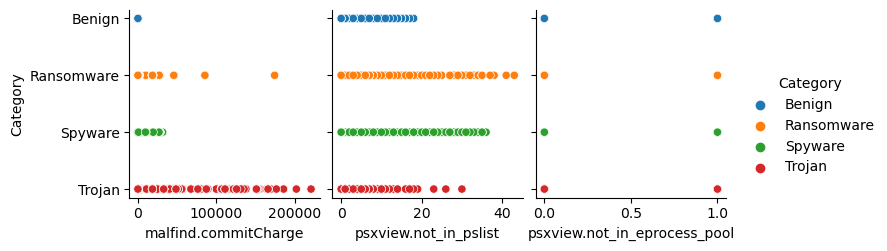

In [141]:
sns.pairplot(dataset1,x_vars=['malfind.commitCharge',
 'psxview.not_in_pslist',
 'psxview.not_in_eprocess_pool'],y_vars=["Category"],hue="Category", kind="scatter")

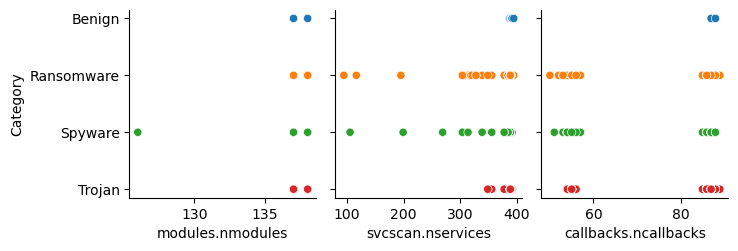

In [142]:
sns.pairplot(dataset1,x_vars=['modules.nmodules',
 'svcscan.nservices',
 'callbacks.ncallbacks'],y_vars=["Category"],hue="Category", kind="scatter")._legend.remove()

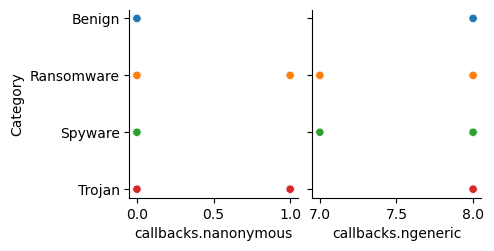

In [143]:
sns.pairplot(dataset1,x_vars=[ 'callbacks.nanonymous',
 'callbacks.ngeneric'],y_vars=["Category"],hue="Category", kind="scatter")._legend.remove()

In [ ]:
#original data 2D visualization
ScaledDataset=dataset1.copy()
ScaledDataset.drop(["Category","Class", "Family"], axis=1, inplace= True)
scale= StandardScaler()
scaled_data = scale.fit_transform(ScaledDataset) 

In [ ]:
scaled_data=np.array(scaled_data)
ScaledDataset=pd.DataFrame(scaled_data,columns=dataset1.drop(["Category","Class", "Family"], axis=1).columns)
ScaledDataset["Category"]= dataset.Category
ScaledDataset["Class"]= dataset.Class
ScaledDataset["Family"]= dataset.Family
X2D = ScaledDataset.drop(["Category","Class","Family"], axis= 1)

In [ ]:
#Using umap for dimension reduction
raw = umap.UMAP(
  n_components=2, n_neighbors=20).fit_transform(X2D)

In [ ]:
rawdata = np.array(raw)
rawdata= pd.DataFrame(rawdata, columns=["x", "y"])
rawdata["Category"]= dataset.Category
rawdata["Class"]= dataset.Class
rawdata["Family"]= dataset.Family

#Diferent perspective of the data
plt.figure(figsize=(7,7))
plt.scatter(rawdata[rawdata.Category=="Benign"]["x"], rawdata[rawdata.Category=="Benign"]["y"], color="green",label= "Benign")
plt.scatter(rawdata[rawdata.Category=="Trojan"]["x"], rawdata[rawdata.Category=="Trojan"]["y"], color= "blue", label="Trojan")
plt.scatter(rawdata[rawdata.Category=="Spyware"]["x"], rawdata[rawdata.Category=="Spyware"]["y"], color="orange",label= "Spyware")
plt.scatter(rawdata[rawdata.Category=="Ransomware"]["x"], rawdata[rawdata.Category=="Ransomware"]["y"], color= "red", label="Ransomware")
plt.title("Original data - Benign and Malware types")
plt.legend()

------------------------------------

### Supervised Clustering

In [144]:
dataset2 = dataset1.copy()
Class = ["Benign", "Malware"] #0,1
Category=['Benign', 'Ransomware', 'Spyware', 'Trojan'] # 0,1,2,3
Family= ['Benign', 'Ako', 'Conti', 'Maze', 'Pysa', 'Shade', '180solutions',
       'CWS', 'Gator', 'TIBS', 'Transponder', 'Emotet', 'Reconyc',
       'Refroso', 'Scar', 'Zeus'] # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
Code1=[0,1]
Code2=[0,1,2,3]
Code3=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

dataset2.Class.replace(Class, Code1, inplace= True)
dataset2.Category.replace(Category, Code2, inplace= True)
dataset2.Family.replace(Family, Code3, inplace= True)


------------------

#### Training a xgboost model

In [145]:
#0 for benign, 1 for ransomware, 2 for spyware, 3 for Trojan
X1 = dataset2.drop(["Category","Class","Family"], axis=1)
Y1 = dataset2["Category"]

x1_train,x1_test, y1_train,y1_test= train_test_split(X1, Y1, test_size=0.2, random_state=0)

In [146]:
#param optimization for gridsearch
params1 = {
    "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    "max_depth": [10,15,20,30,50],
    "min_child_weight": [1,3,5,7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
    "early_stopping_rounds": [25,50,100],
    "n_estimators": [100,200,500]
}

In [147]:
Classifier1= xgb.XGBClassifier()
random_search1=RandomizedSearchCV(Classifier1, param_distributions=params1, n_iter=5, n_jobs=-1,cv=5)

In [148]:
start_time=timer(None)
random_search1.fit(x1_train,y1_train, eval_set=[(x1_test, y1_test)])
timer(start_time)

[0]	validation_0-mlogloss:1.25207
[1]	validation_0-mlogloss:1.14033
[2]	validation_0-mlogloss:1.04515
[3]	validation_0-mlogloss:0.95894
[4]	validation_0-mlogloss:0.88251
[5]	validation_0-mlogloss:0.81913
[6]	validation_0-mlogloss:0.76301
[7]	validation_0-mlogloss:0.71426
[8]	validation_0-mlogloss:0.66833
[9]	validation_0-mlogloss:0.63039
[10]	validation_0-mlogloss:0.59570
[11]	validation_0-mlogloss:0.56137
[12]	validation_0-mlogloss:0.53021
[13]	validation_0-mlogloss:0.50303
[14]	validation_0-mlogloss:0.47744
[15]	validation_0-mlogloss:0.45580
[16]	validation_0-mlogloss:0.43576
[17]	validation_0-mlogloss:0.41714
[18]	validation_0-mlogloss:0.40127
[19]	validation_0-mlogloss:0.38501
[20]	validation_0-mlogloss:0.37083
[21]	validation_0-mlogloss:0.35741
[22]	validation_0-mlogloss:0.34566
[23]	validation_0-mlogloss:0.33442
[24]	validation_0-mlogloss:0.32487
[25]	validation_0-mlogloss:0.31594
[26]	validation_0-mlogloss:0.30705
[27]	validation_0-mlogloss:0.29944
[28]	validation_0-mlogloss:0.2

[231]	validation_0-mlogloss:0.15528
[232]	validation_0-mlogloss:0.15516
[233]	validation_0-mlogloss:0.15512
[234]	validation_0-mlogloss:0.15508
[235]	validation_0-mlogloss:0.15504
[236]	validation_0-mlogloss:0.15501
[237]	validation_0-mlogloss:0.15496
[238]	validation_0-mlogloss:0.15484
[239]	validation_0-mlogloss:0.15483
[240]	validation_0-mlogloss:0.15480
[241]	validation_0-mlogloss:0.15478
[242]	validation_0-mlogloss:0.15473
[243]	validation_0-mlogloss:0.15464
[244]	validation_0-mlogloss:0.15460
[245]	validation_0-mlogloss:0.15454
[246]	validation_0-mlogloss:0.15453
[247]	validation_0-mlogloss:0.15431
[248]	validation_0-mlogloss:0.15417
[249]	validation_0-mlogloss:0.15395
[250]	validation_0-mlogloss:0.15394
[251]	validation_0-mlogloss:0.15388
[252]	validation_0-mlogloss:0.15375
[253]	validation_0-mlogloss:0.15371
[254]	validation_0-mlogloss:0.15369
[255]	validation_0-mlogloss:0.15366
[256]	validation_0-mlogloss:0.15354
[257]	validation_0-mlogloss:0.15342
[258]	validation_0-mlogloss:

[459]	validation_0-mlogloss:0.14473
[460]	validation_0-mlogloss:0.14473
[461]	validation_0-mlogloss:0.14473
[462]	validation_0-mlogloss:0.14470
[463]	validation_0-mlogloss:0.14470
[464]	validation_0-mlogloss:0.14466
[465]	validation_0-mlogloss:0.14457
[466]	validation_0-mlogloss:0.14457
[467]	validation_0-mlogloss:0.14454
[468]	validation_0-mlogloss:0.14454
[469]	validation_0-mlogloss:0.14450
[470]	validation_0-mlogloss:0.14450
[471]	validation_0-mlogloss:0.14448
[472]	validation_0-mlogloss:0.14447
[473]	validation_0-mlogloss:0.14444
[474]	validation_0-mlogloss:0.14442
[475]	validation_0-mlogloss:0.14439
[476]	validation_0-mlogloss:0.14437
[477]	validation_0-mlogloss:0.14436
[478]	validation_0-mlogloss:0.14433
[479]	validation_0-mlogloss:0.14431
[480]	validation_0-mlogloss:0.14431
[481]	validation_0-mlogloss:0.14428
[482]	validation_0-mlogloss:0.14415
[483]	validation_0-mlogloss:0.14409
[484]	validation_0-mlogloss:0.14407
[485]	validation_0-mlogloss:0.14403
[486]	validation_0-mlogloss:

In [149]:
random_search1.best_params_

#The optimal parameters keep slightly changing but the validation score stays around the same values

{'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 30,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'early_stopping_rounds': 100,
 'colsample_bytree': 0.7}

In [150]:
Classifier1= xgb.XGBClassifier(n_estimators=500,
 min_child_weight=7,
 max_depth=20,
 learning_rate=0.2,
 gamma=0.4,
 early_stopping_rounds=50,
 colsample_bytree=0.7)
Classifier1.fit(x1_train,y1_train,eval_set=[(x1_test, y1_test)])

[0]	validation_0-mlogloss:1.13446
[1]	validation_0-mlogloss:0.96159
[2]	validation_0-mlogloss:0.83088
[3]	validation_0-mlogloss:0.72255
[4]	validation_0-mlogloss:0.63515
[5]	validation_0-mlogloss:0.57036
[6]	validation_0-mlogloss:0.51728
[7]	validation_0-mlogloss:0.47424
[8]	validation_0-mlogloss:0.43634
[9]	validation_0-mlogloss:0.40876
[10]	validation_0-mlogloss:0.38502
[11]	validation_0-mlogloss:0.36111
[12]	validation_0-mlogloss:0.34141
[13]	validation_0-mlogloss:0.32493
[14]	validation_0-mlogloss:0.31032
[15]	validation_0-mlogloss:0.29917
[16]	validation_0-mlogloss:0.28994
[17]	validation_0-mlogloss:0.28166
[18]	validation_0-mlogloss:0.27577
[19]	validation_0-mlogloss:0.26975
[20]	validation_0-mlogloss:0.26381
[21]	validation_0-mlogloss:0.25845
[22]	validation_0-mlogloss:0.25512
[23]	validation_0-mlogloss:0.25152
[24]	validation_0-mlogloss:0.24816
[25]	validation_0-mlogloss:0.24516
[26]	validation_0-mlogloss:0.24210
[27]	validation_0-mlogloss:0.24028
[28]	validation_0-mlogloss:0.2

[231]	validation_0-mlogloss:0.18618
[232]	validation_0-mlogloss:0.18615
[233]	validation_0-mlogloss:0.18615
[234]	validation_0-mlogloss:0.18615
[235]	validation_0-mlogloss:0.18610
[236]	validation_0-mlogloss:0.18571
[237]	validation_0-mlogloss:0.18563
[238]	validation_0-mlogloss:0.18560
[239]	validation_0-mlogloss:0.18549
[240]	validation_0-mlogloss:0.18538
[241]	validation_0-mlogloss:0.18519
[242]	validation_0-mlogloss:0.18481
[243]	validation_0-mlogloss:0.18476
[244]	validation_0-mlogloss:0.18419
[245]	validation_0-mlogloss:0.18417
[246]	validation_0-mlogloss:0.18410
[247]	validation_0-mlogloss:0.18403
[248]	validation_0-mlogloss:0.18391
[249]	validation_0-mlogloss:0.18365
[250]	validation_0-mlogloss:0.18353
[251]	validation_0-mlogloss:0.18349
[252]	validation_0-mlogloss:0.18340
[253]	validation_0-mlogloss:0.18340
[254]	validation_0-mlogloss:0.18337
[255]	validation_0-mlogloss:0.18337
[256]	validation_0-mlogloss:0.18335
[257]	validation_0-mlogloss:0.18335
[258]	validation_0-mlogloss:

[459]	validation_0-mlogloss:0.17409
[460]	validation_0-mlogloss:0.17409
[461]	validation_0-mlogloss:0.17408
[462]	validation_0-mlogloss:0.17404
[463]	validation_0-mlogloss:0.17390
[464]	validation_0-mlogloss:0.17387
[465]	validation_0-mlogloss:0.17387
[466]	validation_0-mlogloss:0.17379
[467]	validation_0-mlogloss:0.17379
[468]	validation_0-mlogloss:0.17379
[469]	validation_0-mlogloss:0.17378
[470]	validation_0-mlogloss:0.17378
[471]	validation_0-mlogloss:0.17378
[472]	validation_0-mlogloss:0.17378
[473]	validation_0-mlogloss:0.17378
[474]	validation_0-mlogloss:0.17378
[475]	validation_0-mlogloss:0.17378
[476]	validation_0-mlogloss:0.17377
[477]	validation_0-mlogloss:0.17377
[478]	validation_0-mlogloss:0.17377
[479]	validation_0-mlogloss:0.17376
[480]	validation_0-mlogloss:0.17370
[481]	validation_0-mlogloss:0.17370
[482]	validation_0-mlogloss:0.17358
[483]	validation_0-mlogloss:0.17358
[484]	validation_0-mlogloss:0.17350
[485]	validation_0-mlogloss:0.17348
[486]	validation_0-mlogloss:

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [151]:
y_predxgb1= Classifier1.predict(x1_test)
predictions1 = [round(value) for value in y_predxgb1]
accuracy1 = accuracy_score(y1_test, predictions1)
accuracy1
dataset2["Pred"]=Classifier1.predict(X1)

In [152]:
dataset2

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0                45            17           202.844444           1694   
1                47            19           242.234043           2074   
2                40            14           288.225000           1932   
3                32            13           264.281250           1445   
4                42            16           281.333333           2067   
...             ...           ...                  ...            ...   
58591            37            15           215.486487           1453   
58592            37            14           190.216216           1347   
58593            38            15           210.026316           1448   
58594            37            15           215.513513           1452   
58595            38            15           213.026316           1487   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                        0.030372                    5                    21   
1                        0.036167                   12                    77   
2                        0.026114                    5                     6   
3                        0.021483                    2                     2   
4                        0.047820                   12                    77   
...                           ...                  ...                   ...   
58591                    0.029292                    3                     3   
58592                    0.030958                    3                     3   
58593                    0.029292                    3                     3   
58594                    0.029392                    3                     3   
58595                    0.029255                    3                     3   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                          2                             0               138   
1                          0                             0               138   
2                          0                             0               137   
3                          0                             0               138   
4                          4                             0               138   
...                      ...                           ...               ...   
58591                      1                             0               138   
58592                      0                             0               138   
58593                      2                             0               138   
58594                      0                             0               138   
58595                      3                             0               138   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0                    389                    87                     0   
1                    392                    87                     0   
2                    395                    88                     0   
3                    395                    88                     0   
4                    392                    87                     0   
...                  ...                   ...                   ...   
58591                389                    86                     0   
58592                389                    88                     0   
58593                389                    88                     0   
58594                389                    87                     0   
58595                389                    86                     0   

       callbacks.ngeneric  Category  Class  Family  Pred  
0                       8         0      0       0     1  
1                       8         0      0       0     0  
2                       8         0      0       0     0  
3                       8         0      0       0     0  
4                       8         0      0      

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


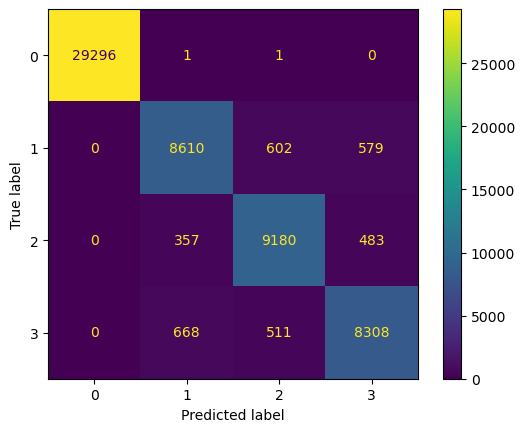

In [153]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(Classifier1, X1, Y1)

-------------------------

#### Computing SHAP values

In [154]:
start_time=timer(None)
explainer1 = shap.TreeExplainer(Classifier1,seed=1)
shap_values1 = explainer1(X1)
timer(start_time)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



 Time taken: 0 hours 2 minutes and 27 seconds.


In [155]:
import matplotlib.colors as colors

gray_val=0.75
cdict = {'red': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)],
        'green': [(0.0, gray_val, gray_val),
                 (1.0, 0.0, 0.0)],
        'blue': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)]}
gray2black = colors.LinearSegmentedColormap(name='red', segmentdata=cdict)

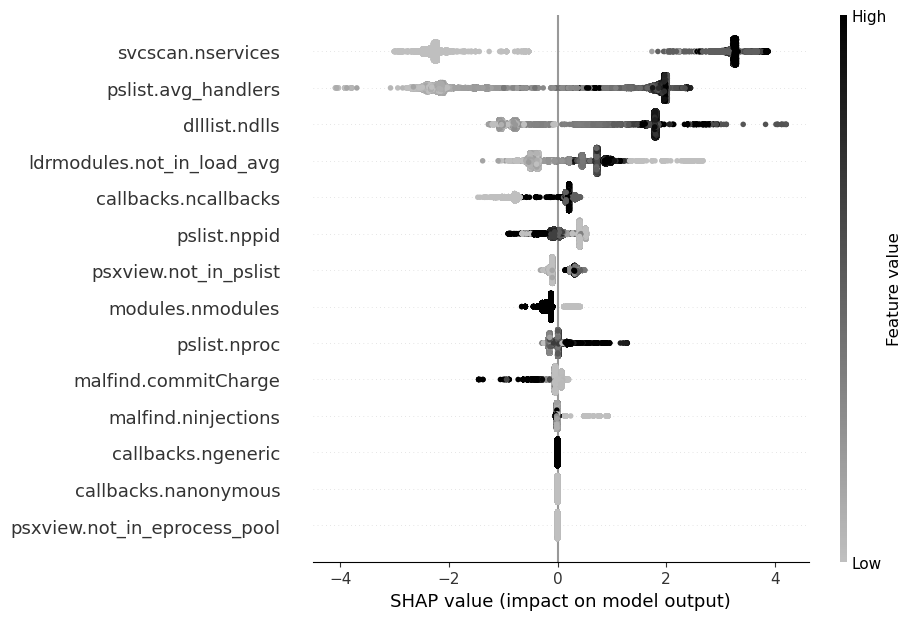

In [156]:
shap.plots.beeswarm(shap_values1[:, :,0], max_display=14,color=plt.get_cmap(gray2black))

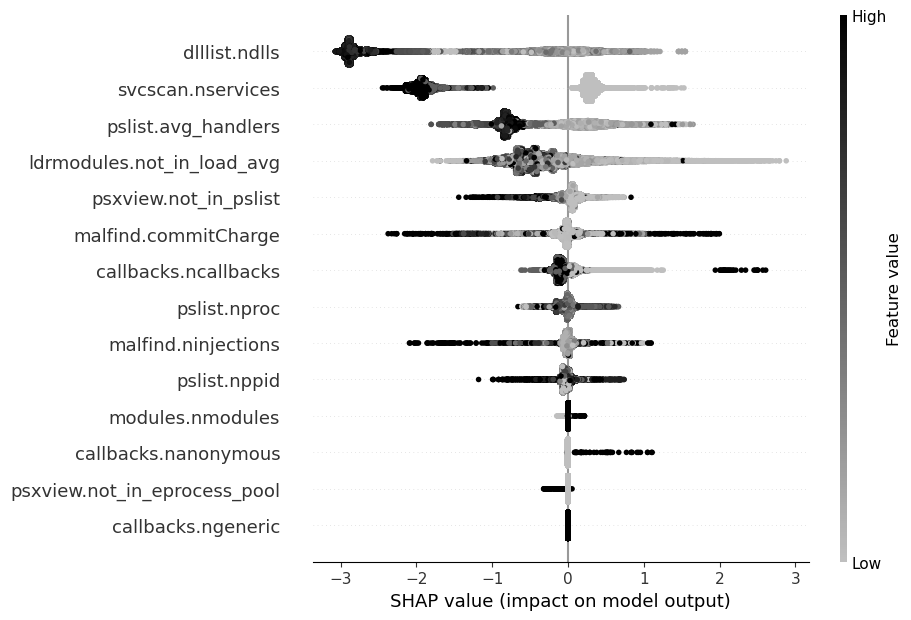

In [157]:
shap.plots.beeswarm(shap_values1[:, :,1], max_display=14,color=plt.get_cmap(gray2black))

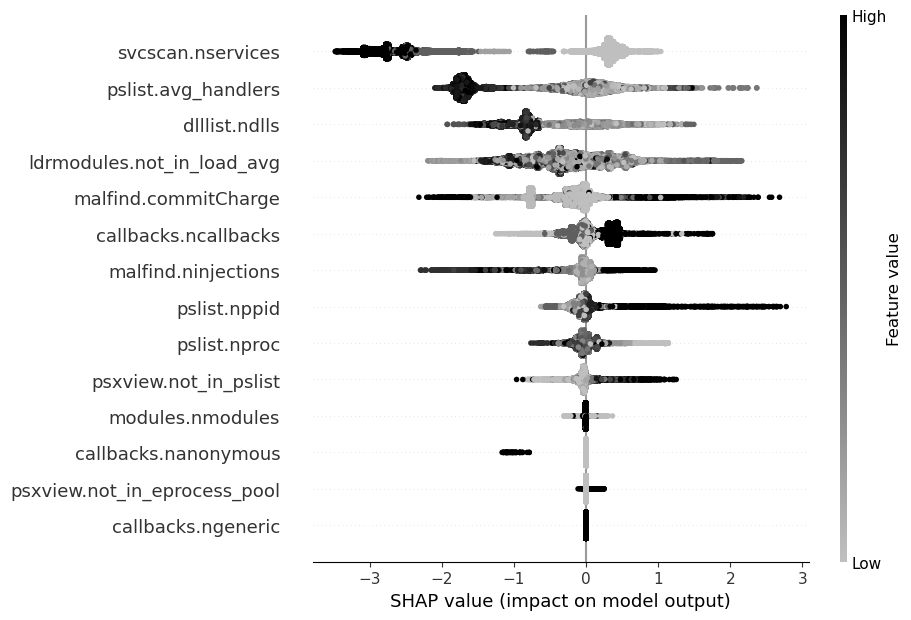

In [158]:
shap.plots.beeswarm(shap_values1[:, :,2], max_display=14,color=plt.get_cmap(gray2black))

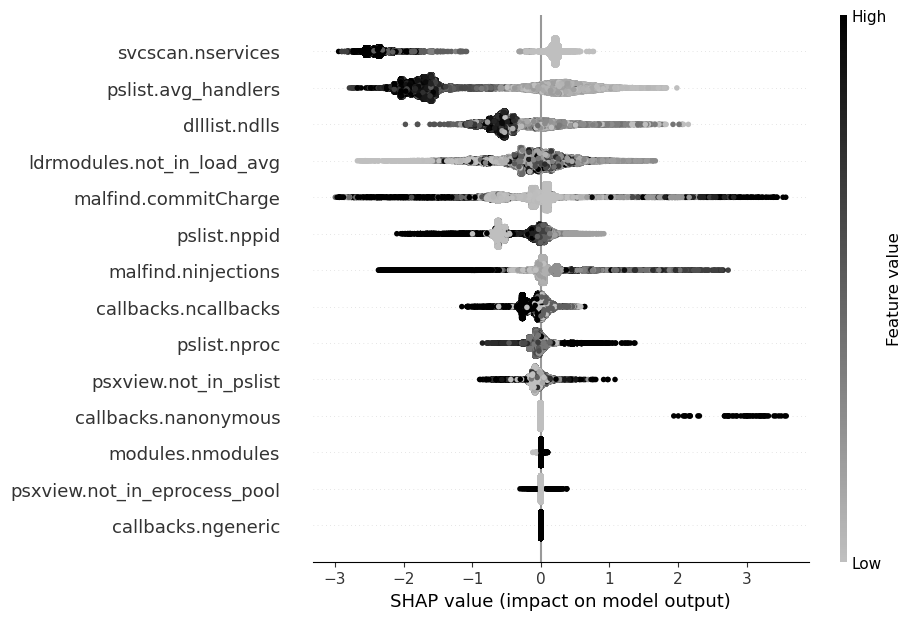

In [159]:
shap.plots.beeswarm(shap_values1[:, :,3], max_display=14,color=plt.get_cmap(gray2black))


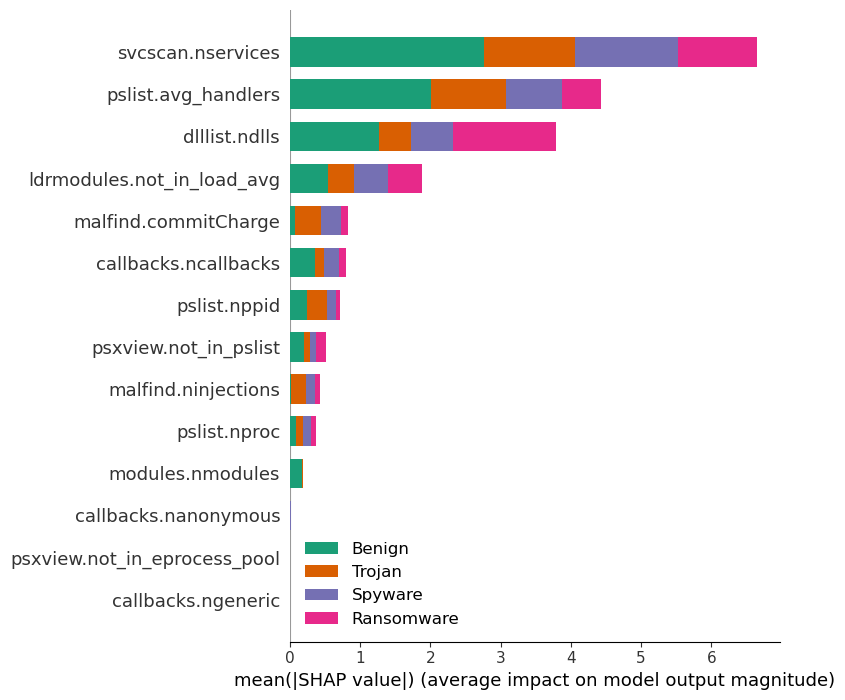

In [160]:
#Overall view of the SHAP features
colorss=["green", "red", "orange", "blue"]
shap_values1.shape
shap.summary_plot(
    [shap_values1[:, :, class_ind].values for class_ind in range(shap_values1.shape[-1])],
    feature_names=X1.columns, class_names=["Benign", "Ransomware", "Spyware", "Trojan"],
    plot_type="bar", max_display=14, color=plt.get_cmap("Dark2")
)

In [161]:
#Merging all the SHAP values in a dataframe
SHAP0=shap_values1[:, :, 0].values
SHAP1=shap_values1[:, :, 1].values
SHAP2=shap_values1[:, :, 2].values
SHAP3=shap_values1[:, :, 3].values


SHAP0 =np.array(SHAP0)
SHAP0 = pd.DataFrame(SHAP0, columns= X1.columns)
SHAP0["Category"]=dataset2.Category
SHAP0["Family"]=dataset2.Family
SHAP0["Class"]=dataset2.Class
SHAP0["Pred"]=dataset2.Pred
SHAP0=SHAP0[SHAP0.Category==0]

SHAP1 =np.array(SHAP1)
SHAP1 = pd.DataFrame(SHAP1, columns= X1.columns)
SHAP1["Category"]=dataset2.Category
SHAP1["Family"]=dataset2.Family
SHAP1["Class"]=dataset2.Class
SHAP1["Pred"]=dataset2.Pred
SHAP1=SHAP1[SHAP1.Category==1]

SHAP2 =np.array(SHAP2)
SHAP2 = pd.DataFrame(SHAP2, columns= X1.columns)
SHAP2["Category"]=dataset2.Category
SHAP2["Family"]=dataset2.Family
SHAP2["Class"]=dataset2.Class
SHAP2["Pred"]=dataset2.Pred
SHAP2=SHAP2[SHAP2.Category==2]

SHAP3 =np.array(SHAP3)
SHAP3 = pd.DataFrame(SHAP3, columns= X1.columns)
SHAP3["Category"]=dataset2.Category
SHAP3["Family"]=dataset2.Family
SHAP3["Class"]=dataset2.Class
SHAP3["Pred"]=dataset2.Pred
SHAP3=SHAP3[SHAP3.Category==3]

DFs=[SHAP0, SHAP1, SHAP2, SHAP3]

SHAPCategoryDF= pd.concat(DFs)

In [162]:
SHAPCategoryDF=SHAPCategoryDF.reset_index()
SHAPCategoryDF.drop(["index"], axis=1,inplace=True)
#SHAPCategoryDF.drop(["level_0"], axis=1,inplace=True)
SHAPCategoryDF

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0          0.350412      0.063625            -1.989797       0.831241   
1          0.194049     -0.440480             1.233939       1.618331   
2          0.001871      0.418995             1.889809       1.564918   
3          0.086237      0.377210             2.285473      -0.751015   
4          0.002018      0.123266             1.767058       1.803147   
...             ...           ...                  ...            ...   
58591     -0.001259     -0.028885             0.877365       0.260789   
58592     -0.008861      0.140619             0.519481      -0.083011   
58593      0.007906      0.071238             0.337469       0.031587   
58594      0.014958      0.044430             0.487662       0.096294   
58595      0.005792      0.038619             0.411245       0.112766   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                        0.093881            -0.013096              0.032637   
1                        0.957638             0.017812             -0.046632   
2                       -0.439990            -0.000612              0.053390   
3                       -0.103341            -0.004337             -0.016074   
4                        0.932027             0.006790             -0.035882   
...                           ...                  ...                   ...   
58591                   -0.319185             0.019873              0.081610   
58592                   -0.186601             0.013068              0.106621   
58593                    0.227495             0.035268              0.093140   
58594                    0.394712             0.053298              0.125281   
58595                    0.642252             0.063146              0.141767   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                   0.456458                      0.000000         -0.117894   
1                  -0.171855                      0.000000         -0.122942   
2                  -0.127162                      0.000000          0.225686   
3                  -0.108179                      0.000000         -0.331195   
4                   0.294487                      0.000000         -0.122942   
...                      ...                           ...               ...   
58591               0.107213                     -0.000493          0.002155   
58592              -0.009771                     -0.000681          0.002173   
58593               0.083215                      0.000602          0.002082   
58594               0.190619                      0.000261          0.002558   
58595               0.135513                      0.000273          0.002558   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0              -2.279282              0.310251              0.000000   
1               2.912940              0.341443              0.000000   
2               3.197052              0.214729              0.000000   
3               3.790831              0.170886              0.000000   
4               3.178946              0.320974              0.000000   
...                  ...                   ...                   ...   
58591           0.207450              0.112909             -0.005473   
58592           0.222558              0.139095             -0.005406   
58593           0.242924              0.079479             -0.005715   
58594           0.249539              0.024556             -0.005815   
58595           0.250910              0.051378             -0.005808   

       callbacks.ngeneric  Category  Family  Class  Pred  
0                     0.0         0       0      0     1  
1                     0.0         0       0      0     0  
2                     0.0         0       0      0     0  
3                     0.0         0       0      0     0  
4                     0.0         0       0     

In [163]:
SHAPCategoryDF1=SHAPCategoryDF.drop(["Category","Class"],axis=1)

-----------------------

#### Reducing SHAP values to 2D

In [213]:
#Reducing the SHAP values to 2 dimensions
start_time=timer(None)
SHAPCategoryUmap = umap.UMAP(
  n_components=2, n_neighbors=10, random_state=0).fit_transform(SHAPCategoryDF1)
timer(start_time)
SHAPCategoryUmap= pd.DataFrame(SHAPCategoryUmap, columns=["x", "y"])
SHAPCategoryUmap["Category"]= SHAPCategoryDF.Category
SHAPCategoryUmap["Class"]= SHAPCategoryDF.Class
SHAPCategoryUmap["Family"]= SHAPCategoryDF.Family
SHAPCategoryUmap["Pred"]= SHAPCategoryDF.Pred


 Time taken: 0 hours 0 minutes and 39 seconds.


--------------------------------------

#### Visualizing the SHAP values

In [214]:
SHAPCategoryUmap

x         y  Category  Class  Family  Pred
0      15.595435  4.351089         0      0       0     1
1     -10.232334  9.251627         0      0       0     0
2      -4.443844 -8.228640         0      0       0     0
3      -1.731832  8.560165         0      0       0     0
4     -13.958913 -3.347938         0      0       0     0
...          ...       ...       ...    ...     ...   ...
58591  10.573516  0.118279         3      1      15     3
58592   5.443736 -7.821181         3      1      15     2
58593  10.665134  1.108382         3      1      15     3
58594  10.967490  1.080075         3      1      15     3
58595  11.286568  1.094150         3      1      15     3

[58596 rows x 6 columns]

In [215]:
MissRan=SHAPCategoryUmap[(SHAPCategoryUmap.Category==1) & (SHAPCategoryUmap.Pred!=1)]
MissTro=SHAPCategoryUmap[(SHAPCategoryUmap.Category==2) & (SHAPCategoryUmap.Pred!=2)]
MissSpy=SHAPCategoryUmap[(SHAPCategoryUmap.Category==3) & (SHAPCategoryUmap.Pred!=3)]


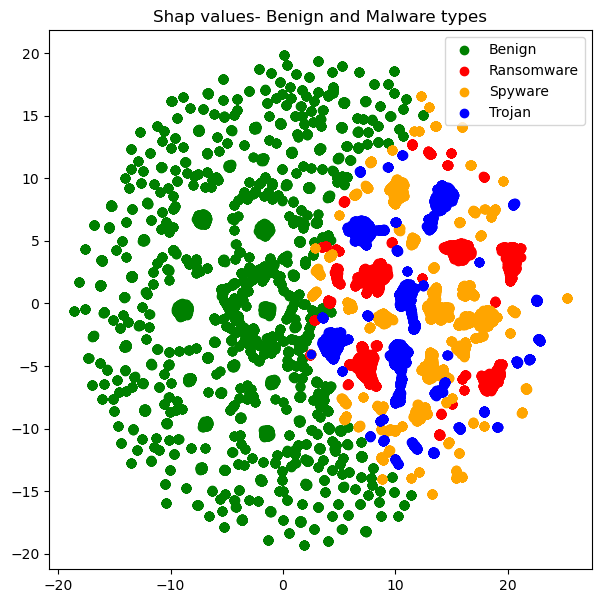

In [216]:
plt.figure(figsize=(7,7))

plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Pred==0]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Pred==0]["y"], color= "green", label= "Benign")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Pred==1]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Pred==1]["y"], color= "red", label= "Ransomware")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Pred==2]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Pred==2]["y"], color= "orange", label= "Spyware")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Pred==3]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Pred==3]["y"], color= "blue", label= "Trojan")
plt.title("Shap values- Benign and Malware types")
plt.legend()
plt.show()

Text(0.5, 1.0, 'SHAP values- Malware types')

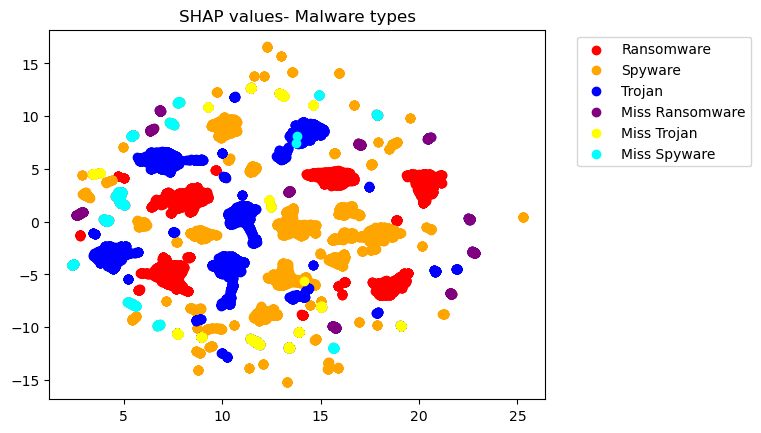

In [217]:
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Pred==1]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Pred==1]["y"], color= "red", label= "Ransomware")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Pred==2]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Pred==2]["y"], color= "orange", label= "Spyware")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Pred==3]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Pred==3]["y"], color= "blue", label= "Trojan")
plt.scatter(MissRan["x"],MissRan["y"], color= "purple", label= "Miss Ransomware")
plt.scatter(MissTro["x"],MissTro["y"], color= "yellow", label= "Miss Trojan")
plt.scatter(MissSpy["x"],MissSpy["y"], color= "aqua", label= "Miss Spyware")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("SHAP values- Malware types")

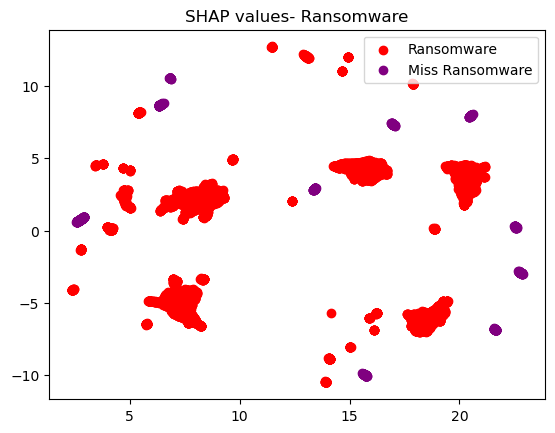

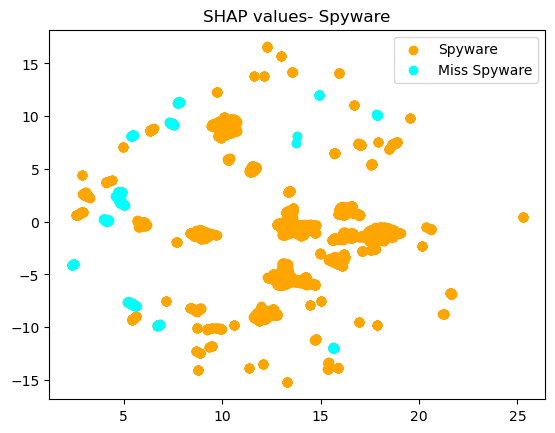

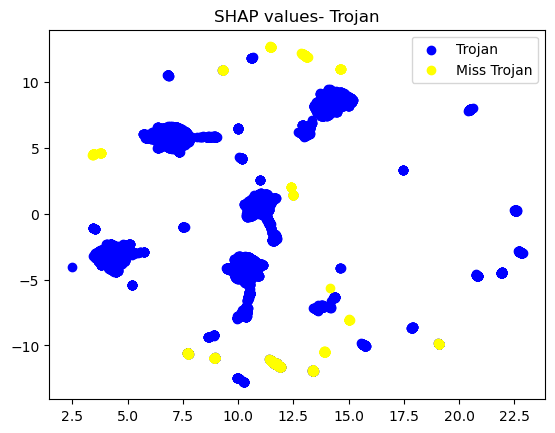

In [218]:

plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Pred==1]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Pred==1]["y"], color= "red", label= "Ransomware")
plt.title("SHAP values- Ransomware")
plt.scatter(MissRan["x"],MissRan["y"], color= "purple", label= "Miss Ransomware")
plt.legend()
plt.show()

plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Pred==2]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Pred==2]["y"], color= "orange", label= "Spyware")
plt.title("SHAP values- Spyware")
plt.scatter(MissSpy["x"],MissSpy["y"], color= "aqua", label= "Miss Spyware")
plt.legend()
plt.show()


plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Pred==3]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Pred==3]["y"], color= "blue", label= "Trojan")
plt.title("SHAP values- Trojan")
plt.scatter(MissTro["x"],MissTro["y"], color= "yellow", label= "Miss Trojan")
plt.legend()
plt.show()

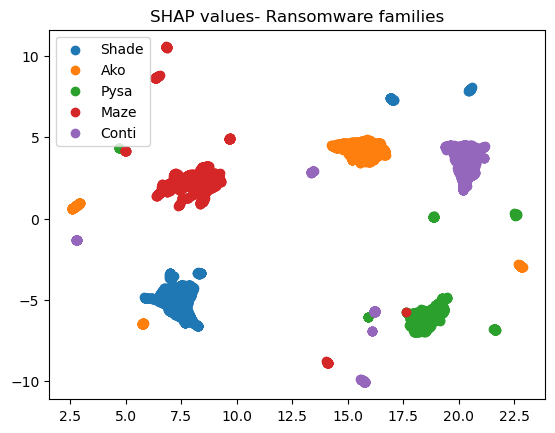

In [219]:
SHAPCategoryUmap.Family.replace(Code3, Family, inplace= True)

plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Shade"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Shade"]["y"], label= "Shade")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Ako"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Ako"]["y"], label= "Ako")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Pysa"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Pysa"]["y"], label= "Pysa")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Maze"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Maze"]["y"], label= "Maze")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Conti"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Conti"]["y"], label= "Conti")
plt.legend(loc='upper left')
plt.title("SHAP values- Ransomware families")
plt.show()



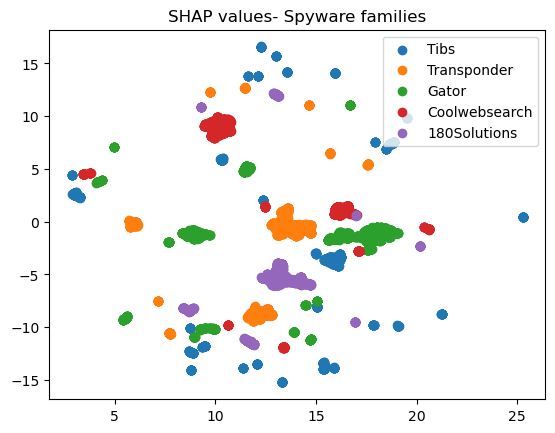

In [220]:

plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="TIBS"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="TIBS"]["y"], label= "Tibs")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Transponder"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Transponder"]["y"], label= "Transponder")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Gator"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Gator"]["y"], label= "Gator")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="CWS"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="CWS"]["y"], label= "Coolwebsearch")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="180solutions"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="180solutions"]["y"], label= "180Solutions")
plt.legend(loc='upper right')
plt.title("SHAP values- Spyware families")
plt.show()


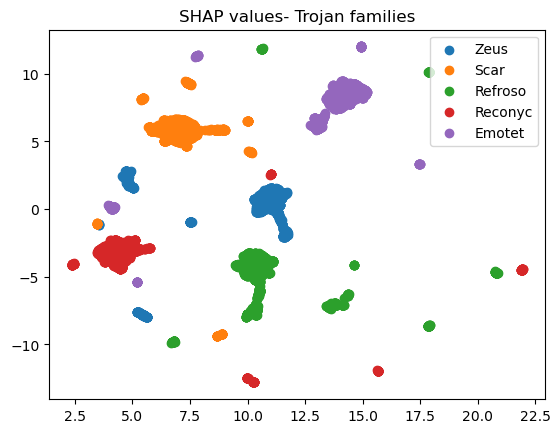

In [221]:

plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Zeus"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Zeus"]["y"], label= "Zeus")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Scar"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Scar"]["y"], label= "Scar")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Refroso"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Refroso"]["y"], label= "Refroso")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Reconyc"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Reconyc"]["y"], label= "Reconyc")
plt.scatter(SHAPCategoryUmap[SHAPCategoryUmap.Family=="Emotet"]["x"], SHAPCategoryUmap[SHAPCategoryUmap.Family=="Emotet"]["y"], label= "Emotet")
plt.legend(loc='upper right')
plt.title("SHAP values- Trojan families")
plt.show()

In [222]:
SHAPCategoryUmap.Family.unique()

array(['Benign', 'Ako', 'Conti', 'Maze', 'Pysa', 'Shade', '180solutions',
       'CWS', 'Gator', 'TIBS', 'Transponder', 'Emotet', 'Reconyc',
       'Refroso', 'Scar', 'Zeus'], dtype=object)

In [223]:
colors=["black","navy","purple","red","sienna","gold", "olivedrab", "darkgreen", "darkcyan","royalblue", "gray","darkorchid","m","orange","slategray","darksalmon", "darkred", "yellow", "palegreen", "aqua", "slategray"]
label=["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3","Cluster 4" ,"Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8", "Cluster 9", "Cluster 10", "Cluster 11","Cluster 12", "Cluster 13", "Cluster 14", "Cluster 15", "Cluster 16", "Cluster 17", "Cluster 18", "Cluster 19", "Cluster 20", "Cluster 21", "Cluster 22", "Cluster 23", "Cluster 24", "Cluster 25", "Cluster 26", "Cluster 27", "Cluster 28", "Cluster 29", "Cluster 30"]

'''
Families=["Benign","Ransomware Families", "Spyware families", "Trojan Families"]
for j in range(len(dataset2.Category.unique())):
    for i in range(len(SHAPCategoryUmap.Family.unique())):
        plt.scatter(SHAPCategoryUmap[(SHAPCategoryUmap.Family==i) & (SHAPCategoryUmap.Category==j)]["x"], SHAPCategoryUmap[(SHAPCategoryUmap.Family==i) & (SHAPCategoryUmap.Category==j)]["y"], color= colors[i])
    plt.title(Families[j]) 
    plt.show()  
'''

'\nFamilies=["Benign","Ransomware Families", "Spyware families", "Trojan Families"]\nfor j in range(len(dataset2.Category.unique())):\n    for i in range(len(SHAPCategoryUmap.Family.unique())):\n        plt.scatter(SHAPCategoryUmap[(SHAPCategoryUmap.Family==i) & (SHAPCategoryUmap.Category==j)]["x"], SHAPCategoryUmap[(SHAPCategoryUmap.Family==i) & (SHAPCategoryUmap.Category==j)]["y"], color= colors[i])\n    plt.title(Families[j]) \n    plt.show()  \n'

--------------------------------

#### DBSCAN clustering

-------------------

In [224]:
SHAPCategoryUmap

x         y  Category  Class  Family  Pred
0      15.595435  4.351089         0      0  Benign     1
1     -10.232334  9.251627         0      0  Benign     0
2      -4.443844 -8.228640         0      0  Benign     0
3      -1.731832  8.560165         0      0  Benign     0
4     -13.958913 -3.347938         0      0  Benign     0
...          ...       ...       ...    ...     ...   ...
58591  10.573516  0.118279         3      1    Zeus     3
58592   5.443736 -7.821181         3      1    Zeus     2
58593  10.665134  1.108382         3      1    Zeus     3
58594  10.967490  1.080075         3      1    Zeus     3
58595  11.286568  1.094150         3      1    Zeus     3

[58596 rows x 6 columns]

#### Focusing on the Malware data

In [225]:
SHAPMalware2D =SHAPCategoryUmap[SHAPCategoryUmap.Class==1]
SHAPMalware2D=SHAPMalware2D.reset_index()
SHAPMalware2D.drop(["index"], axis=1,inplace=True)

Malcode1=[1,2,3] 
MalCode2=["Ransomware", "Spyware", "Trojan"]
SHAPMalware2D.Category.replace(Malcode1, MalCode2,inplace= True)
SHAPMalware2D.Pred.replace(Malcode1, MalCode2,inplace= True)

In [226]:
SHAPMalware2D

x         y    Category  Class Family        Pred
0      22.832973 -2.970564  Ransomware      1    Ako      Trojan
1       2.621987  0.638985  Ransomware      1    Ako     Spyware
2      22.832405 -2.968880  Ransomware      1    Ako      Trojan
3      15.318992  4.327656  Ransomware      1    Ako  Ransomware
4       2.829890  0.845897  Ransomware      1    Ako     Spyware
...          ...       ...         ...    ...    ...         ...
29293  10.573516  0.118279      Trojan      1   Zeus      Trojan
29294   5.443736 -7.821181      Trojan      1   Zeus     Spyware
29295  10.665134  1.108382      Trojan      1   Zeus      Trojan
29296  10.967490  1.080075      Trojan      1   Zeus      Trojan
29297  11.286568  1.094150      Trojan      1   Zeus      Trojan

[29298 rows x 6 columns]

Text(0.5, 1.0, 'SHAP Values- Malware Category data')

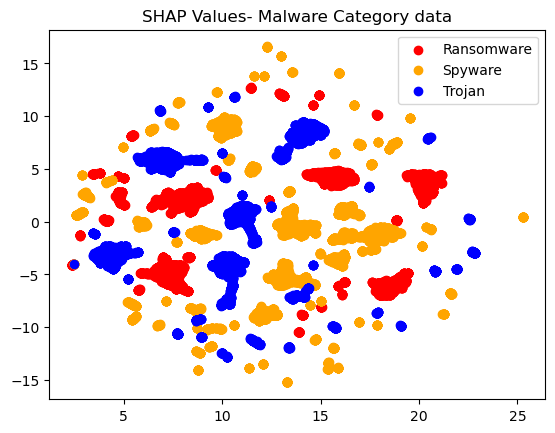

In [227]:
#all malware
plt.scatter(SHAPMalware2D[SHAPMalware2D.Pred=="Ransomware"]["x"], SHAPMalware2D[SHAPMalware2D.Pred=="Ransomware"]["y"], color= "red", label= "Ransomware")
plt.scatter(SHAPMalware2D[SHAPMalware2D.Pred=="Spyware"]["x"], SHAPMalware2D[SHAPMalware2D.Pred=="Spyware"]["y"], color= "orange", label= "Spyware")
plt.scatter(SHAPMalware2D[SHAPMalware2D.Pred=="Trojan"]["x"], SHAPMalware2D[SHAPMalware2D.Pred=="Trojan"]["y"], color= "blue", label= "Trojan")
plt.legend()
plt.title("SHAP Values- Malware Category data")

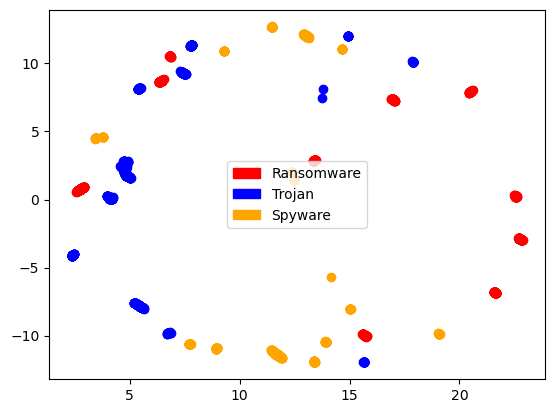

In [228]:
#misclassifications only
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Ransomware')
blue_patch = mpatches.Patch(color='blue', label='Trojan')
orange_patch = mpatches.Patch(color='orange', label='Spyware')
count= 0
for i in range(len(SHAPMalware2D)):
    if SHAPMalware2D["Category"][i]!= SHAPMalware2D["Pred"][i] and SHAPMalware2D["Category"][i]=="Ransomware":
        count+=1
        plt.scatter(SHAPMalware2D["x"][i],SHAPMalware2D["y"][i], color = "red")
    elif SHAPMalware2D["Category"][i]!= SHAPMalware2D["Pred"][i] and SHAPMalware2D["Category"][i]=="Trojan":
        count+=1
        plt.scatter(SHAPMalware2D["x"][i],SHAPMalware2D["y"][i], color = "blue")
    elif SHAPMalware2D["Category"][i]!= SHAPMalware2D["Pred"][i] and SHAPMalware2D["Category"][i]=="Spyware":
        count +=1
        plt.scatter(SHAPMalware2D["x"][i],SHAPMalware2D["y"][i], color = "orange")
plt.legend(handles=[red_patch, blue_patch,orange_patch])
plt.show()

In [229]:
count

3200

-------------------------

#### DBSCAN cluster

In [230]:
DBSCANMalSHAP= DBSCAN(eps=1, min_samples=300).fit(SHAPMalware2D[["x","y"]])
DBSCANPRED3=DBSCANMalSHAP.labels_
SHAPMalware2D["Cluster_DBSCAN"]=DBSCANPRED3

In [231]:
SHAPMalware2D["Cluster_DBSCAN"].unique()

array([-1,  0,  1,  2,  3,  9,  4,  5,  6,  7, 12, 10,  8, 11, 13, 14, 19,
       15, 16, 17, 18], dtype=int64)

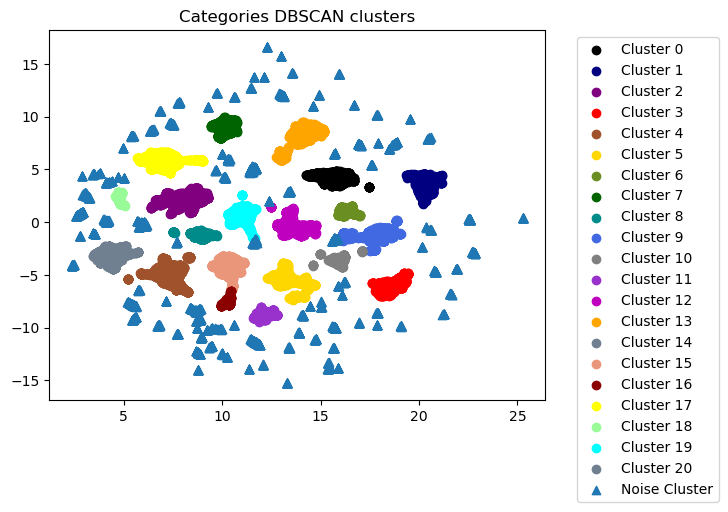

In [232]:
#plt.figure(figsize=(10,10))
for i in range(len(SHAPMalware2D["Cluster_DBSCAN"].unique())):
    plt.scatter(SHAPMalware2D[(SHAPMalware2D.Cluster_DBSCAN==i)]["x"], SHAPMalware2D[(SHAPMalware2D.Cluster_DBSCAN==i)]["y"], label=label[i], color= colors[i])
plt.scatter(SHAPMalware2D[(SHAPMalware2D.Cluster_DBSCAN==-1)]["x"], SHAPMalware2D[(SHAPMalware2D.Cluster_DBSCAN==-1)]["y"], label="Noise Cluster", marker= "^")
plt.title("Categories DBSCAN clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#plt.scatter(SHAPMalware2D[(SHAPMalware2D.Cluster_DBSCAN==-1)]["x"], SHAPMalware2D[(SHAPMalware2D.Cluster_DBSCAN==-1)]["y"], label="Noise Cluster")
#plt.title("SHAP Values- DBSCAN  Noise")

-------------------------

In [233]:
SHAPMalware2D

x         y    Category  Class Family        Pred  \
0      22.832973 -2.970564  Ransomware      1    Ako      Trojan   
1       2.621987  0.638985  Ransomware      1    Ako     Spyware   
2      22.832405 -2.968880  Ransomware      1    Ako      Trojan   
3      15.318992  4.327656  Ransomware      1    Ako  Ransomware   
4       2.829890  0.845897  Ransomware      1    Ako     Spyware   
...          ...       ...         ...    ...    ...         ...   
29293  10.573516  0.118279      Trojan      1   Zeus      Trojan   
29294   5.443736 -7.821181      Trojan      1   Zeus     Spyware   
29295  10.665134  1.108382      Trojan      1   Zeus      Trojan   
29296  10.967490  1.080075      Trojan      1   Zeus      Trojan   
29297  11.286568  1.094150      Trojan      1   Zeus      Trojan   

       Cluster_DBSCAN  
0                  -1  
1                  -1  
2                  -1  
3                   0  
4                  -1  
...               ...  
29293              19  
29294              -1  
29295              19  
29296              19  
29297              19  

[29298 rows x 7 columns]

### Gaussian cluster

Text(0.5, 1.0, 'BIC criteria')

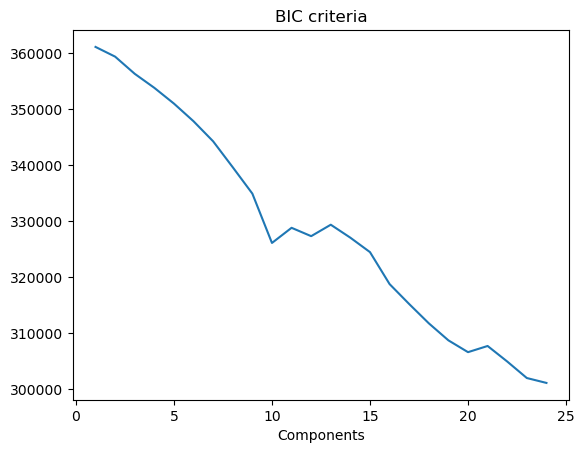

In [234]:
components=np.arange(1,25)
models=[GaussianMixture(n, covariance_type="full", random_state=0).fit(SHAPMalware2D[["x","y"]]) for n in components]
plt.plot(components, [m.bic(SHAPMalware2D[["x","y"]]) for m in models], label="BIC")
plt.xlabel("Components")
plt.title("BIC criteria")

In [235]:
GMSHAPCat20=GaussianMixture(20, covariance_type="full", random_state=0)
Cluster20GMSHAPCat=GMSHAPCat20.fit_predict(SHAPMalware2D[["x","y"]])

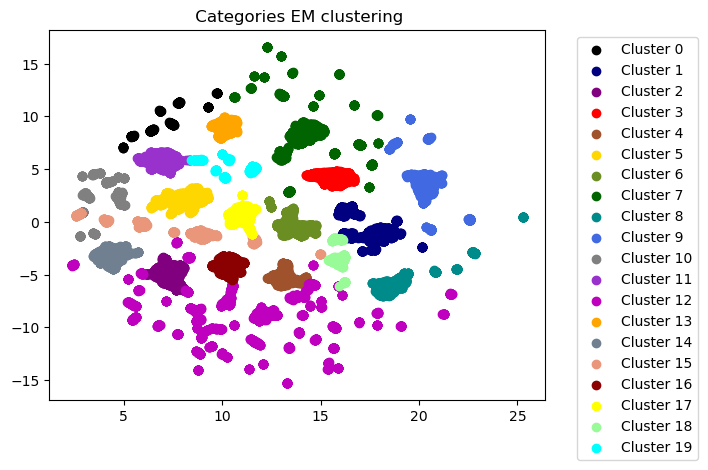

In [236]:
SHAPMalware2D["GM20Cluster"]=Cluster20GMSHAPCat
for i in range(len(SHAPMalware2D.GM20Cluster.unique())):
    plt.scatter(SHAPMalware2D[SHAPMalware2D.GM20Cluster== i]["x"],SHAPMalware2D[SHAPMalware2D.GM20Cluster== i]["y"], color= colors[i], label= label[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(" Categories EM clustering")
plt.show()

### Cluster analysis

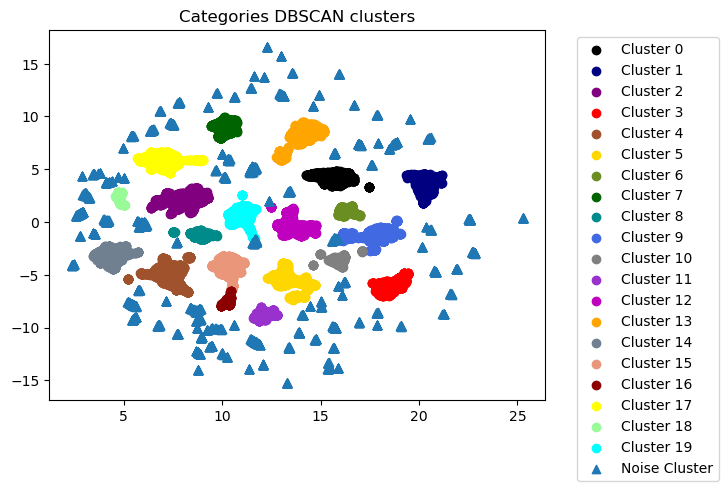

In [237]:
#plt.figure(figsize=(10,10))
for i in range(len(SHAPMalware2D["Cluster_DBSCAN"].unique())-1):
    plt.scatter(SHAPMalware2D[(SHAPMalware2D.Cluster_DBSCAN==i)]["x"], SHAPMalware2D[(SHAPMalware2D.Cluster_DBSCAN==i)]["y"], label=label[i], color= colors[i])
plt.scatter(SHAPMalware2D[(SHAPMalware2D.Cluster_DBSCAN==-1)]["x"], SHAPMalware2D[(SHAPMalware2D.Cluster_DBSCAN==-1)]["y"], label="Noise Cluster", marker= "^")
plt.title("Categories DBSCAN clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [238]:
ClusterAnalsisDF=SHAPCategoryDF.copy()
ClusterAnalsisDF= ClusterAnalsisDF[ClusterAnalsisDF.Class==1]
ClusterAnalsisDF=ClusterAnalsisDF.reset_index()
ClusterAnalsisDF.drop(["index"], axis=1,inplace=True)
ClusterAnalsisDF["Cluster"]=SHAPMalware2D["Cluster_DBSCAN"]

ClusterAnalsisDF.Class.replace(Code1, Class, inplace= True)
ClusterAnalsisDF.Category.replace(Code2, Category, inplace= True)
ClusterAnalsisDF.Family.replace(Code3, Family, inplace= True)
ClusterAnalsisDF.Pred.replace(Code2, Category, inplace= True)

ClusterAnalsisDF

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0         -0.114703     -0.030846             0.445455      -0.424209   
1         -0.041180      0.015527             0.198105      -0.215572   
2         -0.112882     -0.048233             0.103184      -0.368685   
3         -0.168055     -0.036470             0.296596       0.102575   
4         -0.072845     -0.029131             0.343711       0.020329   
...             ...           ...                  ...            ...   
29293     -0.001259     -0.028885             0.877365       0.260789   
29294     -0.008861      0.140619             0.519481      -0.083011   
29295      0.007906      0.071238             0.337469       0.031587   
29296      0.014958      0.044430             0.487662       0.096294   
29297      0.005792      0.038619             0.411245       0.112766   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                       -0.667985            -0.037455             -0.091176   
1                       -0.385796             0.013657             -0.012624   
2                       -0.818537            -0.048179             -0.106900   
3                        0.661602            -0.015193             -0.044239   
4                        0.441242            -0.011194             -0.054584   
...                           ...                  ...                   ...   
29293                   -0.319185             0.019873              0.081610   
29294                   -0.186601             0.013068              0.106621   
29295                    0.227495             0.035268              0.093140   
29296                    0.394712             0.053298              0.125281   
29297                    0.642252             0.063146              0.141767   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                  -0.230775                      0.000936          0.001585   
1                   0.047284                      0.000932          0.001319   
2                  -0.308806                      0.000698          0.001496   
3                   0.056848                      0.000377          0.001461   
4                   0.144703                      0.000959          0.001473   
...                      ...                           ...               ...   
29293               0.107213                     -0.000493          0.002155   
29294              -0.009771                     -0.000681          0.002173   
29295               0.083215                      0.000602          0.002082   
29296               0.190619                      0.000261          0.002558   
29297               0.135513                      0.000273          0.002558   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0               0.257436              0.184617             -0.000508   
1               0.213450             -0.053914             -0.000791   
2               0.232746             -0.027041             -0.000456   
3               0.309871             -0.166419             -0.001335   
4               0.282622             -0.063219             -0.000703   
...                  ...                   ...                   ...   
29293           0.207450              0.112909             -0.005473   
29294           0.222558              0.139095             -0.005406   
29295           0.242924              0.079479             -0.005715   
29296           0.249539              0.024556             -0.005815   
29297           0.250910              0.051378             -0.005808   

       callbacks.ngeneric    Category Family    Class        Pred  Cluster  
0                     0.0  Ransomware    Ako  Malware      Trojan       -1  
1                     0.0  Ransomware    Ako  Malware     Spyware       -1  
2                     0.0  Ransomware    Ako  Malware      Trojan       -1  
3                     0.0  Ransomwa

In [239]:
#Validar o nr de msissclasified samples
count= 0
for i in range(len(ClusterAnalsisDF)):
    if ClusterAnalsisDF["Category"][i] != ClusterAnalsisDF["Pred"][i]:
        count+=1
count

3200

In [240]:
ClusterAnalsisDF.columns

Index(['pslist.nproc', 'pslist.nppid', 'pslist.avg_handlers', 'dlllist.ndlls',
       'ldrmodules.not_in_load_avg', 'malfind.ninjections',
       'malfind.commitCharge', 'psxview.not_in_pslist',
       'psxview.not_in_eprocess_pool', 'modules.nmodules', 'svcscan.nservices',
       'callbacks.ncallbacks', 'callbacks.nanonymous', 'callbacks.ngeneric',
       'Category', 'Family', 'Class', 'Pred', 'Cluster'],
      dtype='object')

Text(0.5, 1.0, 'DBSCAN clusters size')

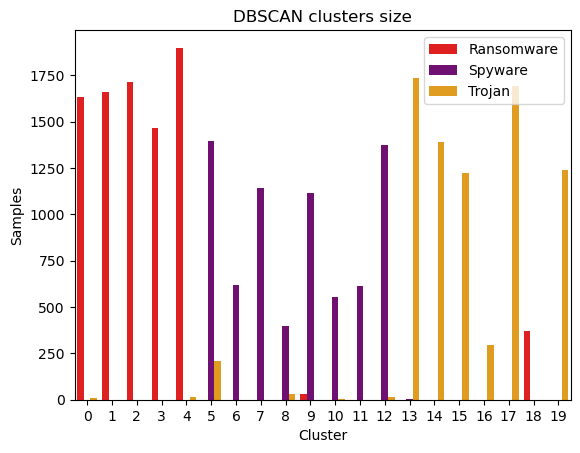

In [241]:
ax=sns.countplot(x="Cluster", hue= "Pred", data=ClusterAnalsisDF[ClusterAnalsisDF.Cluster!=-1], palette=["Red", "Purple", "Orange"])

ax.grid(False)
plt.legend(loc="upper right")
plt.ylabel("Samples")
plt.title("DBSCAN clusters size")

In [279]:
MeanDF= ClusterAnalsisDF[ClusterAnalsisDF.Cluster!=-1]



#0-2
Mean3=MeanDF[(MeanDF.Cluster==0) | (MeanDF.Cluster==1) | (MeanDF.Cluster==2)]
Mean3=Mean3.groupby(["Cluster"]).mean()
Mean3= Mean3.T

#3,4 ,18
Mean18=MeanDF[(MeanDF.Cluster==3) | (MeanDF.Cluster==4) | (MeanDF.Cluster==18)]
Mean18=Mean18.groupby(["Cluster"]).mean()
Mean18= Mean18.T

#5-8
Mean7=MeanDF[(MeanDF.Cluster==8) | (MeanDF.Cluster==5) | (MeanDF.Cluster==6)| (MeanDF.Cluster==7)]
Mean7=Mean7.groupby(["Cluster"]).mean()
Mean7= Mean7.T

#9-12
Mean11=MeanDF[(MeanDF.Cluster==12) | (MeanDF.Cluster==9) | (MeanDF.Cluster==10)| (MeanDF.Cluster==11)]
Mean11=Mean11.groupby(["Cluster"]).mean()
Mean11= Mean11.T

#13-15
Mean15=MeanDF[(MeanDF.Cluster==13) | (MeanDF.Cluster==14)| (MeanDF.Cluster==15)]
Mean15=Mean15.groupby(["Cluster"]).mean()
Mean15= Mean15.T

#16-19
Mean19=MeanDF[(MeanDF.Cluster==16) | (MeanDF.Cluster==17)| (MeanDF.Cluster==19)]
Mean19=Mean19.groupby(["Cluster"]).mean()
Mean19= Mean19.T



Text(0.5, 1.0, 'Cluster mean SHAP values- Ransomware')

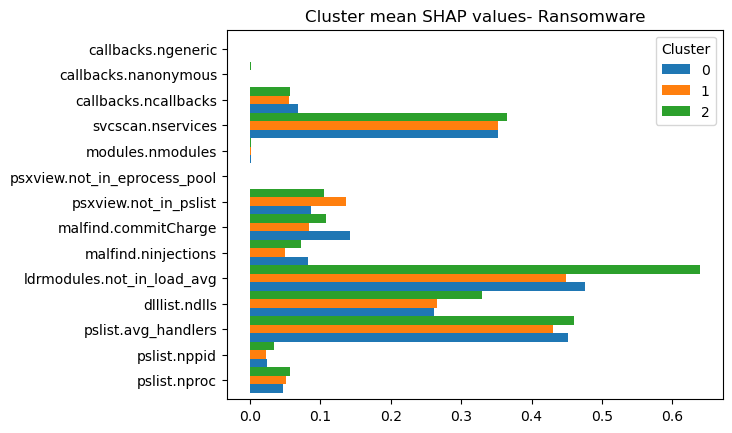

In [280]:
Mean3.plot(kind="barh", width=1)

plt.title("Cluster mean SHAP values- Ransomware")

Text(0.5, 1.0, 'Cluster mean SHAP values- Ransomware')

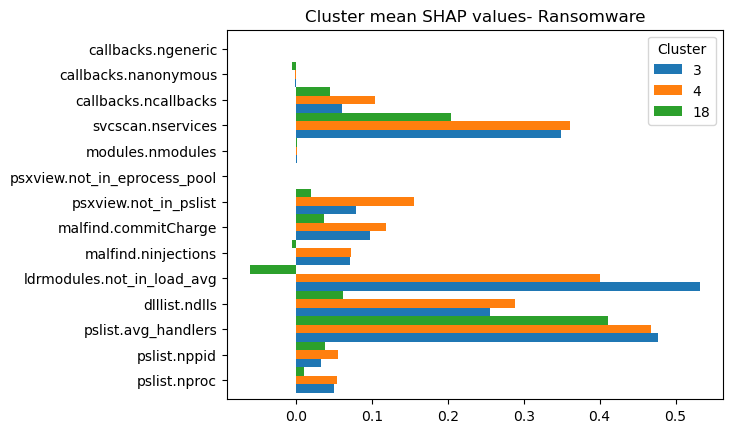

In [281]:
Mean18.plot(kind="barh", width=1)

plt.title("Cluster mean SHAP values- Ransomware")

Text(0.5, 1.0, 'Cluster mean SHAP values- Spyware')

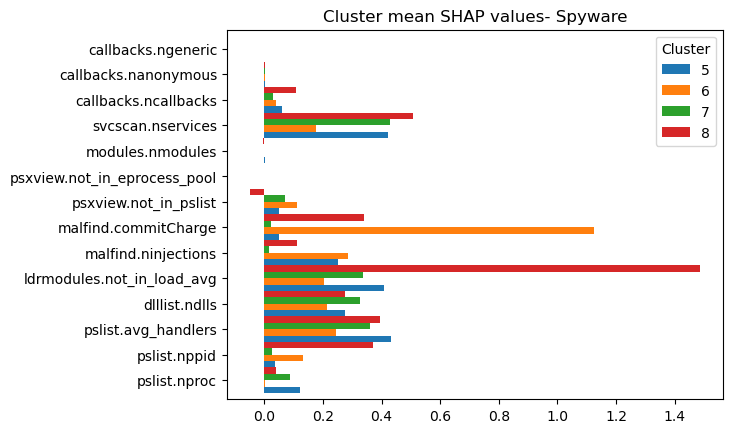

In [282]:
Mean7.plot(kind="barh", width=1)

plt.title("Cluster mean SHAP values- Spyware")

Text(0.5, 1.0, 'Cluster mean SHAP values- Spyware')

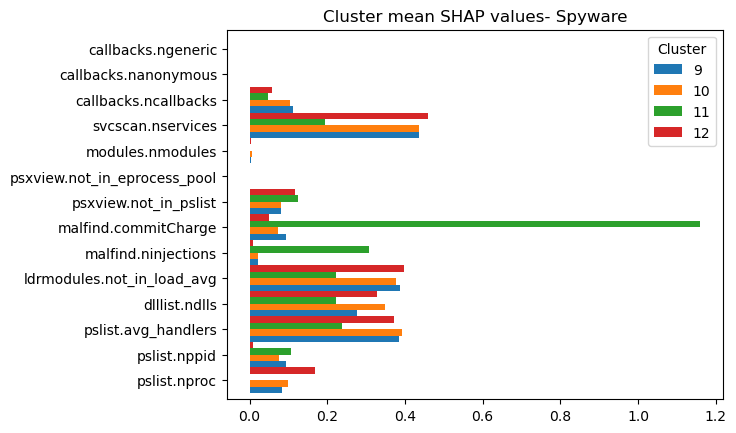

In [283]:
Mean11.plot(kind="barh", width=1)

plt.title("Cluster mean SHAP values- Spyware")

Text(0.5, 1.0, 'Cluster mean SHAP values- Trojan')

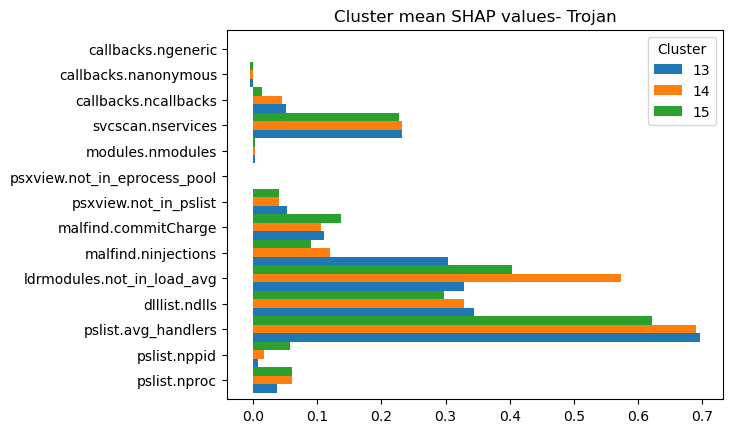

In [284]:
Mean15.plot(kind="barh", width=1)

plt.title("Cluster mean SHAP values- Trojan")

Text(0.5, 1.0, 'Cluster mean SHAP values- Trojan')

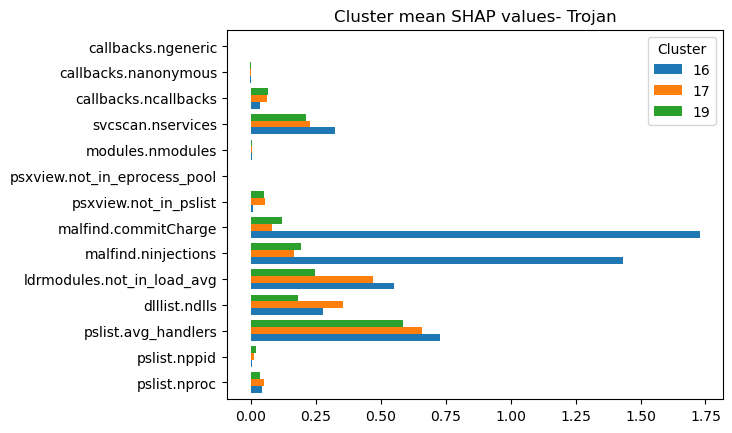

In [287]:
Mean19.plot(kind="barh", width=0.8)
            
plt.title("Cluster mean SHAP values- Trojan")

Text(0.5, 1.0, 'Cluster mean SHAP values- 16 to 19')

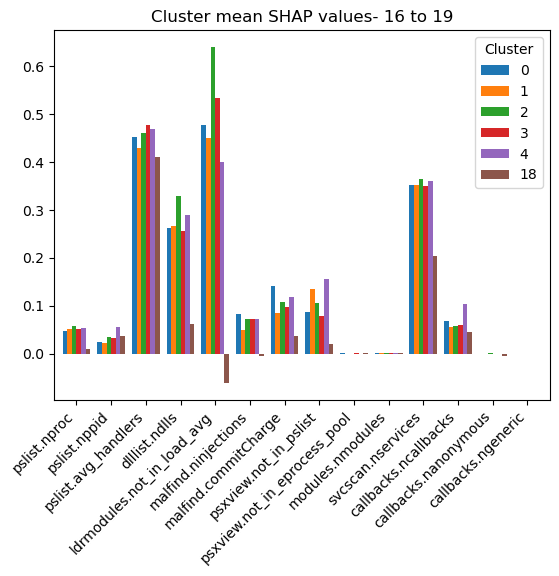

In [264]:
MeanSpyware=MeanDF[(MeanDF.Cluster==0) |(MeanDF.Cluster==1) | (MeanDF.Cluster==2)|(MeanDF.Cluster==3) | (MeanDF.Cluster==4)|  (MeanDF.Cluster==18)]
MeanSpyware=MeanSpyware.groupby(["Cluster"]).mean()
MeanSpyware= MeanSpyware.T

MeanSpyware.plot(kind="bar", width=0.8)
plt.xticks(
rotation=45, 
horizontalalignment='right',
fontweight='light',
 )
plt.title("Cluster mean SHAP values- 16 to 19")

### Extra analysis

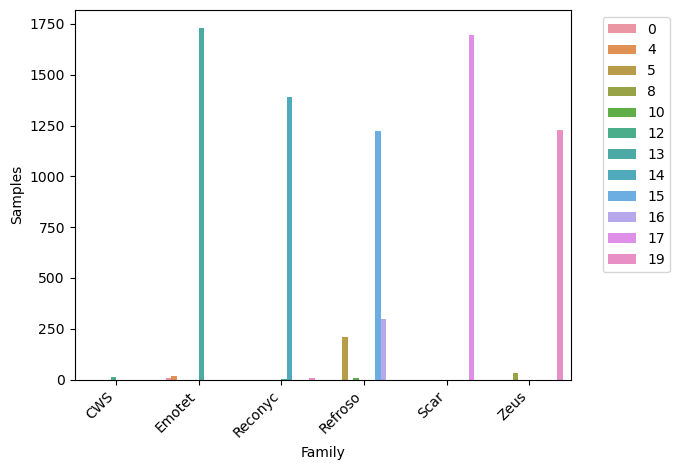

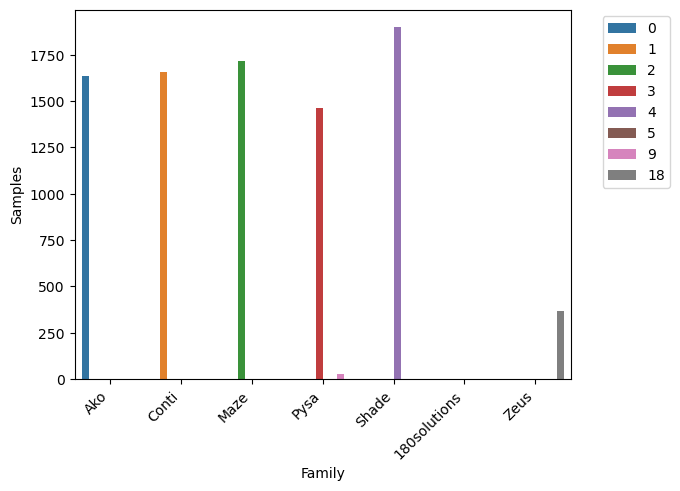

Text(0, 0.5, 'Samples')

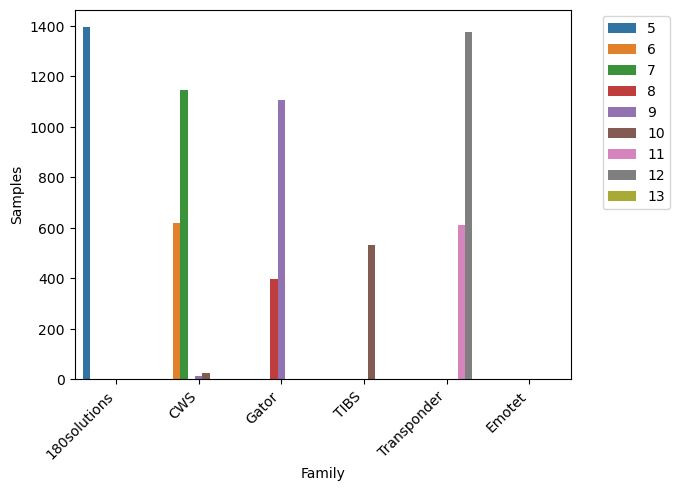

In [249]:
ax=sns.countplot(x="Family", hue= "Cluster", data=ClusterAnalsisDF[(ClusterAnalsisDF.Cluster!=-1) & (ClusterAnalsisDF.Pred=="Trojan")])
ax.grid(False)

plt.xticks(
rotation=45, 
horizontalalignment='right',
fontweight='light',
#fontsize='x-large'  
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Samples")
plt.show()

#2
ax=sns.countplot(x="Family", hue= "Cluster", data=ClusterAnalsisDF[(ClusterAnalsisDF.Cluster!=-1) & (ClusterAnalsisDF.Pred=="Ransomware")])
ax.grid(False)

plt.xticks(
rotation=45, 
horizontalalignment='right',
fontweight='light',
#fontsize='x-large'  
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Samples")
plt.show()

#3
ax=sns.countplot(x="Family", hue= "Cluster", data=ClusterAnalsisDF[(ClusterAnalsisDF.Cluster!=-1) & (ClusterAnalsisDF.Pred=="Spyware")])
ax.grid(False)

plt.xticks(
rotation=45, 
horizontalalignment='right',
fontweight='light',
#fontsize='x-large'  
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Samples")

In [250]:
SpywareSHAP=SHAPMalware2D[SHAPMalware2D.Category=="Spyware"][["x","y", "Category", "Family"]] 
RansomwareSHAP=SHAPMalware2D[SHAPMalware2D.Category=="Ransomware"][["x","y", "Category", "Family"]]  
TrojanSHAP=SHAPMalware2D[SHAPMalware2D.Category=="Trojan"][["x","y", "Category", "Family"]]  

Text(0.5, 1.0, 'SHAP Values- Malware Data')

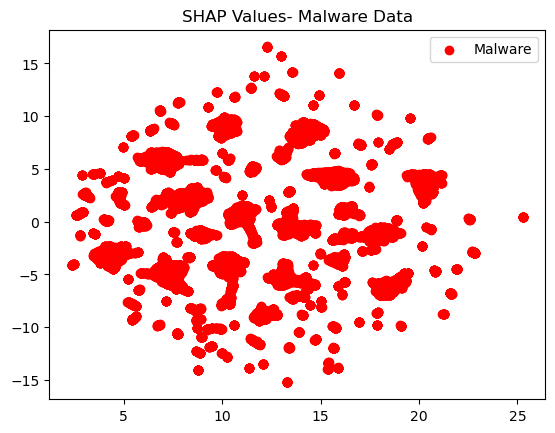

In [251]:
plt.scatter(SHAPMalware2D["x"], SHAPMalware2D["y"], color= "red", label= "Malware")
plt.legend()
plt.title("SHAP Values- Malware Data")

-------------------------------------------

In [252]:
DBSCANSHAP1= DBSCAN(eps=1, min_samples=600).fit(SHAPCategoryUmap[["x","y"]])
DBSCANPRED2=DBSCANSHAP1.labels_
SHAPCategoryUmap["Cluster_DBSCAN"]=DBSCANPRED2

In [253]:
#SHAPCategoryUmap["Class"]=SHAPCategoryDF.Class
SHAPCategoryUmap["Category"]=SHAPCategoryDF.Category
SHAPCategoryUmap["Family"]=SHAPCategoryDF.Family

SHAPCategoryUmap.Class.replace(Code1, Class, inplace= True)
SHAPCategoryUmap.Category.replace(Code2, Category, inplace= True)
SHAPCategoryUmap.Pred.replace(Code2, Category, inplace= True)
SHAPCategoryUmap.Family.replace(Code3, Family, inplace= True)
SHAPCategoryUmap

x         y Category    Class  Family        Pred  \
0      15.595435  4.351089   Benign   Benign  Benign  Ransomware   
1     -10.232334  9.251627   Benign   Benign  Benign      Benign   
2      -4.443844 -8.228640   Benign   Benign  Benign      Benign   
3      -1.731832  8.560165   Benign   Benign  Benign      Benign   
4     -13.958913 -3.347938   Benign   Benign  Benign      Benign   
...          ...       ...      ...      ...     ...         ...   
58591  10.573516  0.118279   Trojan  Malware    Zeus      Trojan   
58592   5.443736 -7.821181   Trojan  Malware    Zeus     Spyware   
58593  10.665134  1.108382   Trojan  Malware    Zeus      Trojan   
58594  10.967490  1.080075   Trojan  Malware    Zeus      Trojan   
58595  11.286568  1.094150   Trojan  Malware    Zeus      Trojan   

       Cluster_DBSCAN  
0                   0  
1                  -1  
2                  -1  
3                  -1  
4                  -1  
...               ...  
58591              22  
58592              -1  
58593              22  
58594              22  
58595              22  

[58596 rows x 7 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


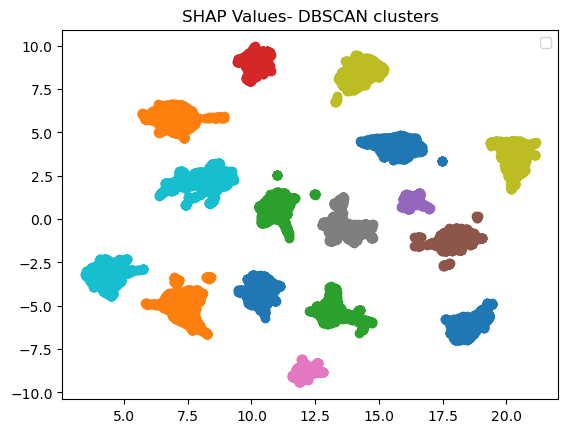

In [254]:
for i in range(len(SHAPCategoryUmap["Cluster_DBSCAN"].unique())):
    plt.scatter(SHAPCategoryUmap[(SHAPCategoryUmap.Cluster_DBSCAN==i) & (SHAPCategoryUmap.Class== "Malware")]["x"], SHAPCategoryUmap[(SHAPCategoryUmap.Cluster_DBSCAN==i) & (SHAPCategoryUmap.Class== "Malware")]["y"])
    
plt.title("SHAP Values- DBSCAN clusters")
plt.legend()
plt.show()

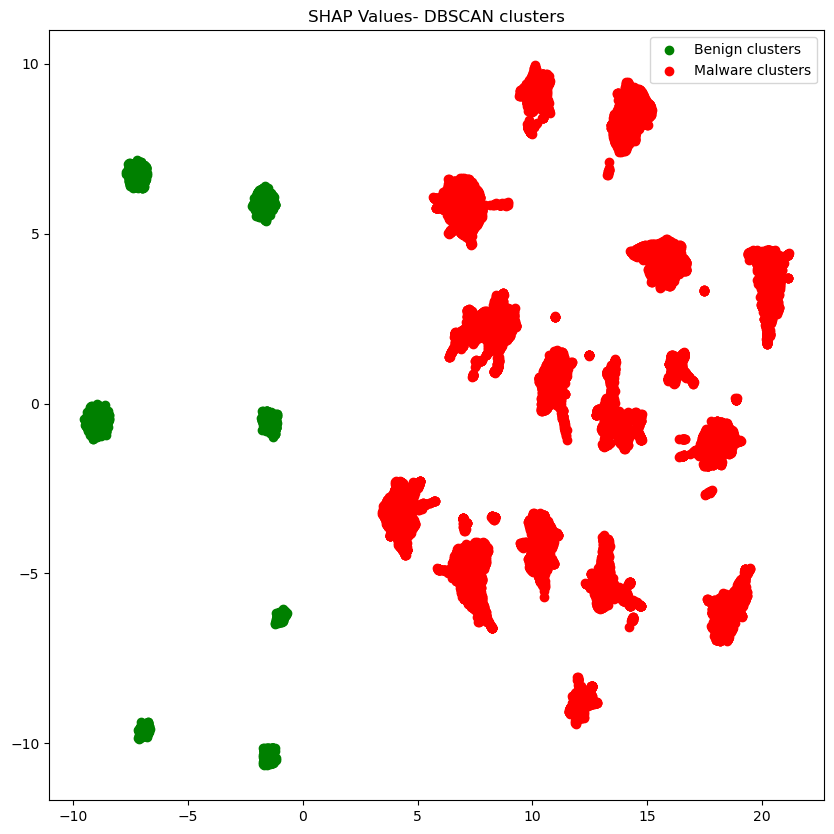

In [255]:
plt.figure(figsize=(10,10))
for i in range(len(SHAPCategoryUmap["Cluster_DBSCAN"].unique())):
    plt.scatter(SHAPCategoryUmap[(SHAPCategoryUmap.Cluster_DBSCAN==i) & (SHAPCategoryUmap.Class== "Benign")]["x"], SHAPCategoryUmap[(SHAPCategoryUmap.Cluster_DBSCAN==i) & (SHAPCategoryUmap.Class== "Benign")]["y"], color= "green")
    plt.scatter(SHAPCategoryUmap[(SHAPCategoryUmap.Cluster_DBSCAN==i) & (SHAPCategoryUmap.Class== "Malware")]["x"], SHAPCategoryUmap[(SHAPCategoryUmap.Cluster_DBSCAN==i) & (SHAPCategoryUmap.Class== "Malware")]["y"], color= "red")
plt.title("SHAP Values- DBSCAN clusters")
plt.legend(["Benign clusters", "Malware clusters"])
plt.show()

In [256]:
DBSCANRansomSHAP=DBSCAN(eps=1, min_samples=100).fit(RansomwareSHAP[["x","y"]])
RansomwareSHAP["Cluster_DBSCAN"]=DBSCANRansomSHAP.labels_

Text(0.5, 1.0, 'Ransomware DBCluster')

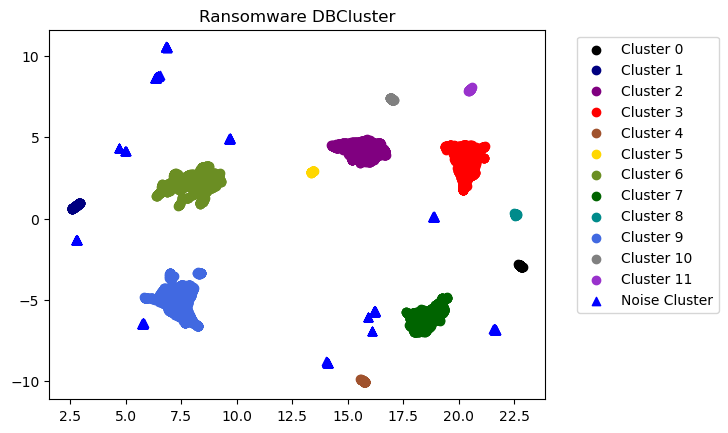

In [288]:
#plt.figure(figsize=(15,15))
for i in range(len(RansomwareSHAP["Cluster_DBSCAN"].unique())-1):
    plt.scatter(RansomwareSHAP[RansomwareSHAP.Cluster_DBSCAN==i]["x"], RansomwareSHAP[RansomwareSHAP.Cluster_DBSCAN==i]["y"], label= label[i], color= colors[i])

plt.scatter(RansomwareSHAP[RansomwareSHAP.Cluster_DBSCAN==-1]["x"], RansomwareSHAP[RansomwareSHAP.Cluster_DBSCAN==-1]["y"], label= "Noise Cluster", color= "blue", marker= "^")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Ransomware DBCluster")

In [258]:
DBSCANTrojanSHAP=DBSCAN(eps=1, min_samples=75).fit(TrojanSHAP[["x","y"]])
TrojanSHAP["Cluster_DBSCAN"]=DBSCANTrojanSHAP.labels_

Text(0.5, 1.0, 'Trojan DBCluster')

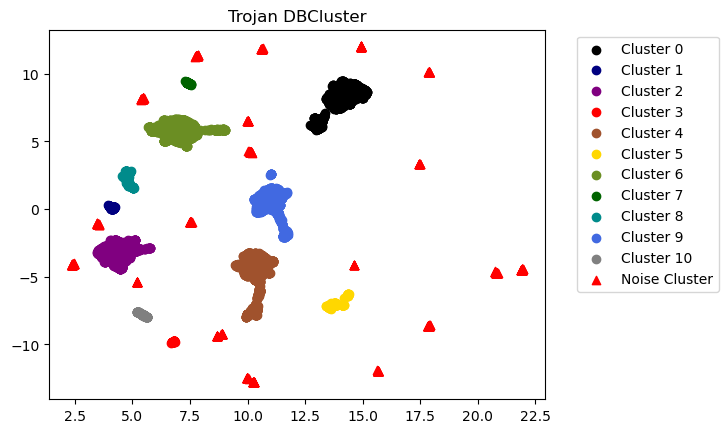

In [289]:
#plt.figure(figsize=(15,15))
for i in range(len(TrojanSHAP["Cluster_DBSCAN"].unique())-1):
    plt.scatter(TrojanSHAP[TrojanSHAP.Cluster_DBSCAN==i]["x"], TrojanSHAP[TrojanSHAP.Cluster_DBSCAN==i]["y"], label= label[i], color= colors[i])

plt.scatter(TrojanSHAP[TrojanSHAP.Cluster_DBSCAN==-1]["x"], TrojanSHAP[TrojanSHAP.Cluster_DBSCAN==-1]["y"], label= "Noise Cluster", color= "red", marker= "^")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')   
plt.title("Trojan DBCluster")

In [260]:
DBSCANSpySHAP=DBSCAN(eps=1, min_samples=100).fit(SpywareSHAP[["x","y"]])
SpywareSHAP["Cluster_DBSCAN"]=DBSCANSpySHAP.labels_

Text(0.5, 1.0, 'Spyware DBCluster')

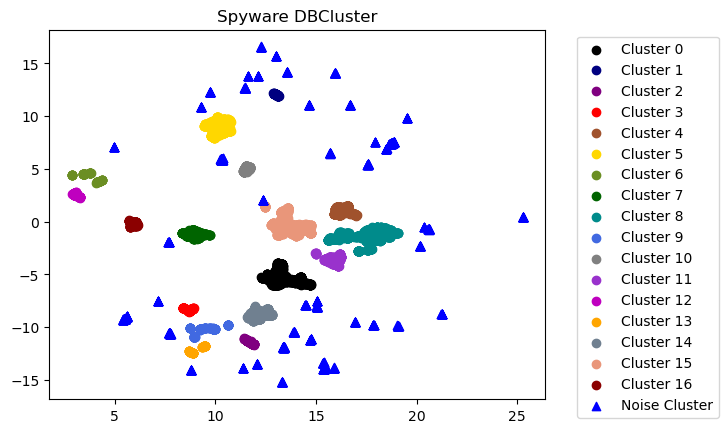

In [290]:
#plt.figure(figsize=(15,15))
for i in range(len(SpywareSHAP["Cluster_DBSCAN"].unique())-1):
    plt.scatter(SpywareSHAP[SpywareSHAP.Cluster_DBSCAN==i]["x"], SpywareSHAP[SpywareSHAP.Cluster_DBSCAN==i]["y"], label= label[i], color= colors[i])

plt.scatter(SpywareSHAP[SpywareSHAP.Cluster_DBSCAN==-1]["x"], SpywareSHAP[SpywareSHAP.Cluster_DBSCAN==-1]["y"], label= "Noise Cluster", color= "blue", marker= "^")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.title("Spyware DBCluster")
    